## ***Flujo del EDA Deportivo por Match en Python***

# Paso 1. Conexion y Carga

In [1]:
# Imports básicos para análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime, timedelta
import json

# Imports para base de datos
import psycopg2
from sqlalchemy import create_engine
import sqlite3

# Imports para análisis avanzado
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Imports para visualizaciones especializadas
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Configuración de warnings y display
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Configuración de matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Configuración de seaborn
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)


In [2]:
# Paso 1. Conexión y Configuración de Base de Datos

# Configuración de la base de datos PostgreSQL
class DatabaseConfig:
    HOST = "localhost"
    PORT = 5432
    DATABASE = "2. PremierLeague"  # Add your database name here
    USER = "admin"
    PASSWORD = "GadumUNITEC123"

# Función para crear conexión a la base de datos
def create_db_connection():
    """Crear conexión a PostgreSQL usando psycopg2"""
    try:
        conn = psycopg2.connect(
            host=DatabaseConfig.HOST,
            port=DatabaseConfig.PORT,
            database=DatabaseConfig.DATABASE,
            user=DatabaseConfig.USER,
            password=DatabaseConfig.PASSWORD
        )
        print("Conexión a PostgreSQL establecida correctamente")
        return conn
    except Exception as e:
        print(f"Error conectando a la base de datos: {e}")
        return None

# Función para crear engine de SQLAlchemy es útil para pandas
def create_sqlalchemy_engine():
    """Crear engine de SQLAlchemy para usar con pandas"""
    try:
        connection_string = f"postgresql://{DatabaseConfig.USER}:{DatabaseConfig.PASSWORD}@{DatabaseConfig.HOST}:{DatabaseConfig.PORT}/{DatabaseConfig.DATABASE}"
        engine = create_engine(connection_string)
        print("Engine SQLAlchemy creado correctamente")
        return engine
    except Exception as e:
        print(f"Error creando engine SQLAlchemy: {e}")
        return None

# Probar conexión
test_conn = create_db_connection()
if test_conn:
    test_conn.close()
    print("Conexión de prueba exitosa - Base de datos disponible")
else:
    print("No se pudo establecer conexión - Verificar configuración")

Conexión a PostgreSQL establecida correctamente
Conexión de prueba exitosa - Base de datos disponible


In [3]:
# Paso 2. Funciones para Cargar Datos de las Tablas

def load_matches_registered():
    """Cargar datos de la tabla matches_registered"""
    # Primero intentar cargar solo las columnas que seguro existen
    query = """
    SELECT 
        match_id, season_id, home_team, away_team, 
        matchday, date_game
    FROM matches_registered
    ORDER BY season_id, matchday, match_id
    """
    
    try:
        engine = create_sqlalchemy_engine()
        if engine is None:
            return None
            
        df = pd.read_sql_query(query, engine)
        print(f"Datos cargados: {len(df)} registros de matches")
        print(f"Matches únicos: {df['match_id'].nunique()}")
        print(f"Temporadas: {sorted(df['season_id'].unique())}")
        
        return df
    except Exception as e:
        print(f"Error cargando matches_registered: {e}")
        return None

def load_team_match_stats():
    """Cargar datos de la tabla team_match_stats - USA team_name en vez de team_id"""
    query = """
    SELECT 
        match_id, season_id, team_name, home_away,
        ttl_gls, ttl_ast, ttl_xg, ttl_xag, ttl_pk_made, ttl_pk_att,
        ttl_yellow_cards, ttl_red_cards, ttl_gls_ag, ttl_sot_ag, ttl_saves,
        clean_sheets, ttl_pk_att_ag, ttl_pk_saved, ttl_sh, ttl_sot, pct_sot,
        ttl_avg_sh, ttl_gls_per_sot, ttl_gls_xg_diff, ttl_pass_cmp, ttl_pass_att,
        pct_pass_cmp, ttl_pass_prog, ttl_key_passes, ttl_pass_opp_box,
        ttl_cross_opp_box, ttl_pass_live, ttl_pass_dead, ttl_pass_fk,
        ttl_through_balls, ttl_switches, ttl_crosses, ttl_pass_offside,
        ttl_pass_blocked, ttl_throw_ins, ttl_ck, ttl_tkl, ttl_tkl_won,
        ttl_tkl_drb, ttl_tkl_drb_att, pct_tkl_drb_suc, ttl_blocks,
        ttl_sh_blocked, ttl_int, ttl_clearances, ttl_def_error, avg_poss,
        ttl_touches, ttl_take_on_att, ttl_take_on_suc, ttl_carries,
        ttl_carries_miscontrolled, ttl_carries_dispossessed, ttl_pass_rcvd,
        ttl_pass_prog_rcvd, ttl_fls_ag, ttl_fls_for, ttl_offside, ttl_og,
        ttl_ball_recov, ttl_air_dual_won, ttl_air_dual_lost, players_count
    FROM team_match_stats
    ORDER BY season_id, match_id, team_name
    """
    
    try:
        engine = create_sqlalchemy_engine()
        if engine is None:
            return None
            
        df = pd.read_sql_query(query, engine)
        print(f"Datos cargados: {len(df)} registros de estadísticas por match")
        print(f"Equipos únicos (por team_name): {df['team_name'].nunique()}")
        print(f"Matches únicos: {df['match_id'].nunique()}")
        
        # IMPORTANTE: Usar team_name como identificador principal
        print(f"\nNOTA: Se usará 'team_name' como identificador de equipo en todos los análisis")
        
        return df
    except Exception as e:
        print(f"Error cargando team_match_stats: {e}")
        return None

# Función para unir ambas tablas
def load_complete_match_data():
    """Cargar y unir datos de ambas tablas"""
    print("Cargando datos de matches...")
    matches_df = load_matches_registered()
    
    print("\nCargando estadísticas de equipos por match...")
    stats_df = load_team_match_stats()
    
    if matches_df is None or stats_df is None:
        print("Error: No se pudieron cargar los datos")
        return None, None, None
    
    # Unir las tablas por match_id
    print("\nUniendo datos...")
    complete_df = pd.merge(
        stats_df, 
        matches_df[['match_id', 'matchday', 'date_game']], 
        on='match_id', 
        how='left'
    )
    
    print(f"Datos unidos: {len(complete_df)} registros")
    print(f"Columnas disponibles: {complete_df.columns.tolist()}")
    
    return matches_df, stats_df, complete_df

# Función de validación
def validate_match_integrity(matches_df, stats_df):
    """Validar la integridad de los datos entre las dos tablas"""
    print("\nVALIDACIÓN DE INTEGRIDAD DE DATOS:")
    print("-" * 50)
    
    # Matches en ambas tablas
    matches_in_both = set(matches_df['match_id']).intersection(set(stats_df['match_id']))
    matches_only_in_matches = set(matches_df['match_id']) - set(stats_df['match_id'])
    matches_only_in_stats = set(stats_df['match_id']) - set(matches_df['match_id'])
    
    print(f"Matches en ambas tablas: {len(matches_in_both)}")
    print(f"Matches solo en matches_registered: {len(matches_only_in_matches)}")
    print(f"Matches solo en team_match_stats: {len(matches_only_in_stats)}")
    
    # Verificar equipos por match en stats
    teams_per_match = stats_df.groupby('match_id')['team_name'].count()
    print(f"\nEquipos por match (debería ser 2):")
    print(teams_per_match.value_counts().sort_index())
    
    # Verificar que cada match tenga un equipo home y uno away
    home_away_check = stats_df.groupby('match_id')['home_away'].apply(lambda x: set(x))
    correct_format = sum([s == {'Home', 'Away'} for s in home_away_check])
    print(f"\nMatches con formato correcto (Home + Away): {correct_format}/{len(home_away_check)}")
    
    if len(matches_only_in_matches) > 0:
        print(f"\n⚠️ Advertencia: {len(matches_only_in_matches)} matches sin estadísticas")
    
    if len(matches_only_in_stats) > 0:
        print(f"\n⚠️ Advertencia: {len(matches_only_in_stats)} estadísticas sin match registrado")
    
    return {
        'matches_in_both': len(matches_in_both),
        'matches_only_in_matches': len(matches_only_in_matches),
        'matches_only_in_stats': len(matches_only_in_stats),
        'teams_per_match': teams_per_match,
        'correct_format_count': correct_format
    }

In [4]:
# Función para crear estructura de directorios por temporada y matchday

def create_match_directory_structure():
    """Crear estructura de directorios para análisis por match"""
    
    base_dir = 'eda_outputsMatchesPremierLeague' # Directorio base para cada liga
    
    # Crear directorio base
    os.makedirs(base_dir, exist_ok=True)
    
    # Temporadas a analizar
    seasons = [
        '2017-2018', '2018-2019', '2019-2020', 
        '2020-2021', '2021-2022', '2022-2023', 
        '2023-2024', '2024-2025', '2025-2026'
    ]
    
    created_dirs = []
    
    for season in seasons:
        # Directorio por temporada
        season_dir = os.path.join(base_dir, f'season_{season}')
        os.makedirs(season_dir, exist_ok=True)
        created_dirs.append(season_dir)
        
        # Subdirectorios por matchday (típicamente 1-38 en Premier League)
        for matchday in range(1, 39):  # Matchdays 1-38
            matchday_dir = os.path.join(season_dir, f'matchday_{matchday:02d}')
            os.makedirs(matchday_dir, exist_ok=True)
        
        # Directorio de resúmenes por temporada
        summary_dir = os.path.join(season_dir, '_season_summary')
        os.makedirs(summary_dir, exist_ok=True)
    
    # Directorio para análisis general
    general_dir = os.path.join(base_dir, '_general_analysis')
    os.makedirs(general_dir, exist_ok=True)
    created_dirs.append(general_dir)
    
    print(f"Estructura de directorios creada:")
    print(f"Directorio base: {base_dir}")
    print(f"Temporadas: {len(seasons)}")
    print(f"Matchdays por temporada: 38")
    print(f"Directorio general de análisis creado")
    
    return base_dir, created_dirs

# Crear estructura de directorios
output_base_dir, created_directories = create_match_directory_structure()

Estructura de directorios creada:
Directorio base: eda_outputsMatchesPremierLeague
Temporadas: 9
Matchdays por temporada: 38
Directorio general de análisis creado


In [5]:
# Cargar todos los datos para el análisis

print("INICIANDO CARGA DE DATOS PARA EDA POR MATCH")
print("="*60)

# Cargar datos completos
matches_data, team_stats_data, complete_match_data = load_complete_match_data()

if complete_match_data is not None:
    print("\nRESUMEN DE DATOS CARGADOS:")
    print(f"Total de registros: {len(complete_match_data):,}")
    print(f"Matches únicos: {complete_match_data['match_id'].nunique():,}")
    print(f"Equipos únicos: {complete_match_data['team_name'].nunique()}")
    print(f"Temporadas: {sorted(complete_match_data['season_id'].unique())}")
    
    # Información por temporada
    print("\nDATOS POR TEMPORADA:")
    season_summary = complete_match_data.groupby('season_id').agg({
        'match_id': 'nunique',
        'team_name': 'nunique',
        'matchday': ['min', 'max']
    }).round(2)
    
    season_summary.columns = ['Matches', 'Teams', 'Min_Matchday', 'Max_Matchday']
    print(season_summary)
    
    # Verificar datos faltantes
    print("\nVERIFICACIÓN DE DATOS FALTANTES:")
    missing_data = complete_match_data.isnull().sum()
    missing_cols = missing_data[missing_data > 0]
    
    if len(missing_cols) > 0:
        print("Columnas con datos faltantes:")
        for col, count in missing_cols.items():
            pct = (count / len(complete_match_data)) * 100
            print(f"  {col}: {count} ({pct:.1f}%)")
    else:
        print("No hay datos faltantes en el dataset")
    
    print(f"\nDatos listos para análisis EDA por Match")
    print("="*60)
else:
    print("Error: No se pudieron cargar los datos completos")

INICIANDO CARGA DE DATOS PARA EDA POR MATCH
Cargando datos de matches...
Engine SQLAlchemy creado correctamente
Datos cargados: 3188 registros de matches
Matches únicos: 3188
Temporadas: ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025', '2025-26']

Cargando estadísticas de equipos por match...
Engine SQLAlchemy creado correctamente
Datos cargados: 6370 registros de estadísticas por match
Equipos únicos (por team_name): 39
Matches únicos: 3185

NOTA: Se usará 'team_name' como identificador de equipo en todos los análisis

Uniendo datos...
Datos unidos: 6370 registros
Columnas disponibles: ['match_id', 'season_id', 'team_name', 'home_away', 'ttl_gls', 'ttl_ast', 'ttl_xg', 'ttl_xag', 'ttl_pk_made', 'ttl_pk_att', 'ttl_yellow_cards', 'ttl_red_cards', 'ttl_gls_ag', 'ttl_sot_ag', 'ttl_saves', 'clean_sheets', 'ttl_pk_att_ag', 'ttl_pk_saved', 'ttl_sh', 'ttl_sot', 'pct_sot', 'ttl_avg_sh', 'ttl_gls_per_sot', 'ttl_gls_xg_diff', 'ttl_pass_cmp',

# Paso 2. Limpieza y Preparacion de Datos por Match

In [6]:
# Funciones para validación y limpieza de datos por match

def validate_match_integrity(complete_df):
    print("VALIDANDO INTEGRIDAD DE MATCHES")
    print("-" * 40)
    
    validation_results = {}
    
    # 1. Verificar que cada match tenga exactamente 2 equipos
    matches_team_count = complete_df.groupby('match_id')['team_name'].count()
    incomplete_matches = matches_team_count[matches_team_count != 2]
    
    if len(incomplete_matches) > 0:
        print(f"Matches incompletos encontrados: {len(incomplete_matches)}")
        validation_results['incomplete_matches'] = incomplete_matches.index.tolist()
    else:
        print("Todos los matches tienen exactamente 2 equipos")
        validation_results['incomplete_matches'] = []
    
    # 2. Verificar coherencia home/away por match
    home_away_check = complete_df.groupby('match_id')['home_away'].apply(
        lambda x: set(x) == {'home', 'away'}
    )
    invalid_home_away = home_away_check[~home_away_check]
    
    if len(invalid_home_away) > 0:
        print(f"Matches con problemas home/away: {len(invalid_home_away)}")
        validation_results['invalid_home_away'] = invalid_home_away.index.tolist()
    else:
        print("Coherencia home/away correcta")
        validation_results['invalid_home_away'] = []
    
    # 3. Verificar que matchday esté en rango válido (1-38)
    invalid_matchdays = complete_df[
        (complete_df['matchday'] < 1) | (complete_df['matchday'] > 38)
    ]
    
    if len(invalid_matchdays) > 0:
        print(f"Matchdays inválidos: {len(invalid_matchdays)}")
        validation_results['invalid_matchdays'] = invalid_matchdays['match_id'].unique().tolist()
    else:
        print("Todos los matchdays están en rango válido (1-38)")
        validation_results['invalid_matchdays'] = []
    
    # 4. Verificar duplicados (mismo match_id, team_name)
    duplicates = complete_df.duplicated(subset=['match_id', 'team_name'], keep=False)
    
    if duplicates.any():
        print(f"Registros duplicados encontrados: {duplicates.sum()}")
        validation_results['duplicates'] = complete_df[duplicates]['match_id'].unique().tolist()
    else:
        print("No hay registros duplicados")
        validation_results['duplicates'] = []
    
    return validation_results

def clean_invalid_data(complete_df, validation_results):
    """Limpiar datos inválidos basado en validación"""
    
    print(f"\nLIMPIANDO DATOS INVÁLIDOS")
    print("-" * 30)
    
    original_length = len(complete_df)
    cleaned_df = complete_df.copy()
    
    # Remover matches incompletos
    if validation_results['incomplete_matches']:
        cleaned_df = cleaned_df[~cleaned_df['match_id'].isin(validation_results['incomplete_matches'])]
        print(f"Removidos {len(validation_results['incomplete_matches'])} matches incompletos")
    
    # Remover matches con problemas home/away
    if validation_results['invalid_home_away']:
        cleaned_df = cleaned_df[~cleaned_df['match_id'].isin(validation_results['invalid_home_away'])]
        print(f"Removidos {len(validation_results['invalid_home_away'])} matches con problemas home/away")
    
    # Remover matchdays inválidos
    if validation_results['invalid_matchdays']:
        cleaned_df = cleaned_df[~cleaned_df['match_id'].isin(validation_results['invalid_matchdays'])]
        print(f"Removidos {len(validation_results['invalid_matchdays'])} matches con matchdays inválidos")
    
    # Remover duplicados
    if validation_results['duplicates']:
        cleaned_df = cleaned_df.drop_duplicates(subset=['match_id', 'team_name'], keep='first')
        print(f"Removidos duplicados")
    
    final_length = len(cleaned_df)
    removed_records = original_length - final_length
    
    print(f"Registros originales: {original_length:,}")
    print(f"Registros finales: {final_length:,}")
    print(f"Registros removidos: {removed_records:,} ({removed_records/original_length*100:.1f}%)")
    
    return cleaned_df

In [7]:
# Manejo de datos faltantes específico para análisis por match

def handle_missing_data(df):    
    print("ANÁLISIS DE DATOS FALTANTES")
    print("-" * 35)
    
    # Calcular porcentaje de datos faltantes por columna
    missing_stats = df.isnull().sum()
    missing_pct = (missing_stats / len(df) * 100).round(2)
    
    missing_df = pd.DataFrame({
        'Missing_Count': missing_stats,
        'Missing_Percentage': missing_pct
    })
    missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
    
    if len(missing_df) > 0:
        print("Columnas con datos faltantes:")
        print(missing_df)
        
        # Estrategias de imputación
        df_clean = df.copy()
        
        # Variables numéricas: imputar con 0 (representan conteos/totales)
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if col in missing_df.index:
                missing_count = missing_df.loc[col, 'Missing_Count']
                df_clean[col] = df_clean[col].fillna(0)
                print(f"{col}: {missing_count} valores imputados con 0")
        
        # Variables categóricas: imputar con 'Unknown'
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if col in missing_df.index:
                missing_count = missing_df.loc[col, 'Missing_Count']
                df_clean[col] = df_clean[col].fillna('Unknown')
                print(f"{col}: {missing_count} valores imputados con 'Unknown'")
        
    else:
        print("No hay datos faltantes en el dataset")
        df_clean = df.copy()
    
    # Verificación final
    remaining_missing = df_clean.isnull().sum().sum()
    print(f"\nDatos faltantes restantes: {remaining_missing}")
    
    return df_clean

def validate_numeric_ranges(df):
    """Validar rangos de variables numéricas"""
    
    print("\nVALIDANDO RANGOS NUMÉRICOS")
    print("-" * 30)
    
    validation_issues = []
    
    # Definir rangos esperados para variables clave
    range_validations = {
        'ttl_gls': (0, 15),          # Goles por equipo por partido
        'ttl_gls_ag': (0, 15),       # Goles en contra
        'avg_poss': (0, 100),        # Posesión en porcentaje
        'ttl_xg': (0, 8),            # Expected Goals razonable
        'ttl_sot': (0, 25),          # Tiros al arco
        'ttl_sh': (0, 50),           # Total de tiros
        'pct_pass_cmp': (0, 100),    # Porcentaje de pases completados
        'ttl_yellow_cards': (0, 10), # Tarjetas amarillas
        'ttl_red_cards': (0, 3),     # Tarjetas rojas
        'players_count': (8, 15)     # Jugadores que participaron
    }
    
    for col, (min_val, max_val) in range_validations.items():
        if col in df.columns:
            out_of_range = df[(df[col] < min_val) | (df[col] > max_val)]
            
            if len(out_of_range) > 0:
                print(f"{col}: {len(out_of_range)} valores fuera de rango [{min_val}, {max_val}]")
                validation_issues.append({
                    'column': col,
                    'out_of_range_count': len(out_of_range),
                    'range': (min_val, max_val)
                })
            else:
                print(f"{col}: Todos los valores en rango válido")
    
    return validation_issues

In [8]:
# Crear variables derivadas para análisis por match

def create_derived_variables(df):
    print("CREANDO VARIABLES DERIVADAS")
    print("-" * 30)
    
    df_enhanced = df.copy()
    
    # 1. Variables de resultado del match (calculadas por match_id)
    print("Creando variables de resultado...")
    
    # Obtener información del oponente para cada registro
    match_info = []
    
    for match_id in df_enhanced['match_id'].unique():
        match_data = df_enhanced[df_enhanced['match_id'] == match_id]
        
        if len(match_data) == 2:  # Match completo
            home_team = match_data[match_data['home_away'] == 'home'].iloc[0]
            away_team = match_data[match_data['home_away'] == 'away'].iloc[0]
            
            # Información para equipo local
            match_info.append({
                'match_id': match_id,
                'team_name': home_team['team_name'],
                'opponent_name': away_team['team_name'],
                'goals_for': home_team['ttl_gls'],
                'goals_against': home_team['ttl_gls_ag'],
                'opponent_goals': away_team['ttl_gls'],
                'match_result': 'Win' if home_team['ttl_gls'] > away_team['ttl_gls'] 
                               else 'Draw' if home_team['ttl_gls'] == away_team['ttl_gls'] 
                               else 'Loss'
            })
            
            # Información para equipo visitante
            match_info.append({
                'match_id': match_id,
                'team_name': away_team['team_name'],
                'opponent_name': home_team['team_name'],
                'goals_for': away_team['ttl_gls'],
                'goals_against': away_team['ttl_gls_ag'],
                'opponent_goals': home_team['ttl_gls'],
                'match_result': 'Win' if away_team['ttl_gls'] > home_team['ttl_gls']
                               else 'Draw' if away_team['ttl_gls'] == home_team['ttl_gls']
                               else 'Loss'
            })
    
    # Convertir a DataFrame y unir
    match_info_df = pd.DataFrame(match_info)
    df_enhanced = df_enhanced.merge(match_info_df, on=['match_id', 'team_name'], how='left')
    
    # 2. Variables de eficiencia
    print("Creando variables de eficiencia...")
    
    # Eficiencia ofensiva
    df_enhanced['shot_accuracy'] = np.where(
        df_enhanced['ttl_sh'] > 0,
        df_enhanced['ttl_sot'] / df_enhanced['ttl_sh'] * 100,
        0
    )
    
    df_enhanced['goal_conversion'] = np.where(
        df_enhanced['ttl_sot'] > 0,
        df_enhanced['ttl_gls'] / df_enhanced['ttl_sot'] * 100,
        0
    )
    
    df_enhanced['xg_performance'] = np.where(
        df_enhanced['ttl_xg'] > 0,
        df_enhanced['ttl_gls'] / df_enhanced['ttl_xg'],
        1
    )
    
    # Eficiencia defensiva
    df_enhanced['tackle_success'] = np.where(
        df_enhanced['ttl_tkl'] > 0,
        df_enhanced['ttl_tkl_won'] / df_enhanced['ttl_tkl'] * 100,
        0
    )
    
    df_enhanced['save_percentage'] = np.where(
        (df_enhanced['ttl_saves'] + df_enhanced['ttl_gls_ag']) > 0,
        df_enhanced['ttl_saves'] / (df_enhanced['ttl_saves'] + df_enhanced['ttl_gls_ag']) * 100,
        0
    )
    
    # 3. Variables de intensidad del juego
    print("Creando variables de intensidad...")
    
    df_enhanced['total_shots'] = df_enhanced['ttl_sh']
    df_enhanced['total_cards'] = df_enhanced['ttl_yellow_cards'] + df_enhanced['ttl_red_cards']
    df_enhanced['total_fouls'] = df_enhanced['ttl_fls_for'] + df_enhanced['ttl_fls_ag']
    df_enhanced['possession_dominance'] = df_enhanced['avg_poss'] - 50  # Diferencia vs 50%
    
    # 4. Variables de control del juego
    print("Creando variables de control...")
    
    df_enhanced['pass_dominance'] = np.where(
        df_enhanced['ttl_pass_att'] > 0,
        df_enhanced['ttl_pass_cmp'] / df_enhanced['ttl_pass_att'] * 100,
        0
    )
    
    df_enhanced['key_pass_rate'] = np.where(
        df_enhanced['ttl_pass_cmp'] > 0,
        df_enhanced['ttl_key_passes'] / df_enhanced['ttl_pass_cmp'] * 100,
        0
    )
    
    df_enhanced['progressive_pass_rate'] = np.where(
        df_enhanced['ttl_pass_cmp'] > 0,
        df_enhanced['ttl_pass_prog'] / df_enhanced['ttl_pass_cmp'] * 100,
        0
    )
    
    # 5. Variables categóricas adicionales
    print("Creando variables categóricas...")
    
    # Categorías de resultado
    df_enhanced['result_category'] = df_enhanced['match_result']
    
    # Categorías de performance ofensiva
    df_enhanced['offensive_performance'] = pd.cut(
        df_enhanced['ttl_gls'], 
        bins=[-1, 0, 1, 2, 10], 
        labels=['No Goals', 'Low (1)', 'Medium (2)', 'High (3+)']
    )
    
    # Categorías de posesión
    df_enhanced['possession_style'] = pd.cut(
        df_enhanced['avg_poss'],
        bins=[0, 40, 60, 100],
        labels=['Defensive', 'Balanced', 'Possession']
    )
    
    # 6. Variables de contexto temporal
    print("Creando variables temporales...")
    
    # Fase de la temporada
    df_enhanced['season_phase'] = pd.cut(
        df_enhanced['matchday'],
        bins=[0, 10, 28, 38],
        labels=['Early', 'Mid', 'Late']
    )
    
    new_vars_count = len(df_enhanced.columns) - len(df.columns)
    print(f"{new_vars_count} variables derivadas creadas")
    print(f"Total de columnas: {len(df_enhanced.columns)}")
    
    return df_enhanced

In [9]:
# Ejecutar proceso completo de limpieza y preparación

def run_complete_data_cleaning(complete_df): 
    print("INICIANDO LIMPIEZA COMPLETA DE DATOS")
    print("="*50)
    
    # Paso 1: Validar integridad
    validation_results = validate_match_integrity(complete_df)
    
    # Paso 2: Limpiar datos inválidos
    clean_df = clean_invalid_data(complete_df, validation_results)
    
    # Paso 3: Manejar datos faltantes
    clean_df = handle_missing_data(clean_df)
    
    # Paso 4: Validar rangos numéricos
    validation_issues = validate_numeric_ranges(clean_df)
    
    # Paso 5: Crear variables derivadas
    enhanced_df = create_derived_variables(clean_df)
    
    # Paso 6: Verificación final
    print(f"\nRESUMEN FINAL DE LIMPIEZA")
    print("-" * 30)
    print(f"Registros originales: {len(complete_df):,}")
    print(f"Registros finales: {len(enhanced_df):,}")
    print(f"Columnas originales: {len(complete_df.columns)}")
    print(f"Columnas finales: {len(enhanced_df.columns)}")
    print(f"Matches únicos: {enhanced_df['match_id'].nunique():,}")
    print(f"Equipos únicos: {enhanced_df['team_name'].nunique()}")
    
    return enhanced_df, validation_results

# Ejecutar limpieza completa
if complete_match_data is not None:
    cleaned_match_data, validation_summary = run_complete_data_cleaning(complete_match_data)
    print(f"\nDatos limpios y preparados para análisis")
else:
    print("No hay datos para limpiar")

INICIANDO LIMPIEZA COMPLETA DE DATOS
VALIDANDO INTEGRIDAD DE MATCHES
----------------------------------------
Todos los matches tienen exactamente 2 equipos
Coherencia home/away correcta
Todos los matchdays están en rango válido (1-38)
No hay registros duplicados

LIMPIANDO DATOS INVÁLIDOS
------------------------------
Registros originales: 6,370
Registros finales: 6,370
Registros removidos: 0 (0.0%)
ANÁLISIS DE DATOS FALTANTES
-----------------------------------
No hay datos faltantes en el dataset

Datos faltantes restantes: 0

VALIDANDO RANGOS NUMÉRICOS
------------------------------
ttl_gls: Todos los valores en rango válido
ttl_gls_ag: Todos los valores en rango válido
avg_poss: Todos los valores en rango válido
ttl_xg: Todos los valores en rango válido
ttl_sot: Todos los valores en rango válido
ttl_sh: Todos los valores en rango válido
pct_pass_cmp: Todos los valores en rango válido
ttl_yellow_cards: Todos los valores en rango válido
ttl_red_cards: Todos los valores en rango vál

In [10]:
# Guardar datos limpios para uso posterior

def save_cleaned_data(cleaned_df, output_dir):
    print("GUARDANDO DATOS LIMPIOS")
    print("-" * 25)
    
    try:
        # Guardar CSV completo
        csv_path = os.path.join(output_dir, 'match_data_cleaned.csv')
        cleaned_df.to_csv(csv_path, index=False)
        print(f"CSV guardado: {csv_path}")
        
        # Guardar por temporadas
        seasons_saved = 0
        for season in cleaned_df['season_id'].unique():
            season_data = cleaned_df[cleaned_df['season_id'] == season]
            season_path = os.path.join(output_dir, f'season_{season}', 'season_data.csv')
            season_data.to_csv(season_path, index=False)
            seasons_saved += 1
        
        print(f"{seasons_saved} archivos por temporada guardados")
        
        # Guardar metadatos de limpieza
        metadata = {
            'cleaning_timestamp': datetime.now().isoformat(),
            'original_records': len(complete_match_data) if complete_match_data is not None else 0,
            'final_records': len(cleaned_df),
            'original_columns': len(complete_match_data.columns) if complete_match_data is not None else 0,
            'final_columns': len(cleaned_df.columns),
            'unique_matches': int(cleaned_df['match_id'].nunique()),
            'unique_teams': int(cleaned_df['team_name'].nunique()),
            'seasons': sorted(cleaned_df['season_id'].unique()),
            'validation_issues': validation_summary
        }
        
        metadata_path = os.path.join(output_dir, 'cleaning_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        print(f"Metadatos guardados: {metadata_path}")
        
        print(f"Todos los archivos guardados en: {output_dir}")
        
    except Exception as e:
        print(f"Error guardando datos: {e}")

# Guardar datos limpios
if 'cleaned_match_data' in locals():
    save_cleaned_data(cleaned_match_data, output_base_dir)
    
    # Mostrar muestra de datos limpios
    print(f"\nMUESTRA DE DATOS LIMPIOS:")
    key_columns = ['season_id', 'matchday', 'team_name', 'home_away', 'match_result', 
                   'ttl_gls', 'goals_against', 'shot_accuracy', 'possession_style']
    available_cols = [col for col in key_columns if col in cleaned_match_data.columns]
    
    sample_data = cleaned_match_data[available_cols].head()
    print(sample_data)
else:
    print("No hay datos limpios para guardar")

GUARDANDO DATOS LIMPIOS
-------------------------
CSV guardado: eda_outputsMatchesPremierLeague\match_data_cleaned.csv
9 archivos por temporada guardados
Metadatos guardados: eda_outputsMatchesPremierLeague\cleaning_metadata.json
Todos los archivos guardados en: eda_outputsMatchesPremierLeague

MUESTRA DE DATOS LIMPIOS:
   season_id  matchday       team_name home_away match_result  ttl_gls  \
0  2017-2018         5     Bournemouth      home          Win        2   
1  2017-2018         5        Brighton      away         Loss        1   
2  2017-2018        30       Liverpool      away         Loss        0   
3  2017-2018        30  Manchester Utd      home          Win        2   
4  2017-2018        27       Liverpool      away          Win        2   

   goals_against  shot_accuracy possession_style  
0              1      20.000000              NaN  
1              2      11.111111              NaN  
2              2      14.285714              NaN  
3              0      40.0000

# Paso 3. Estadisticas Descriptivas por Match

INICIANDO ANÁLISIS DESCRIPTIVO COMPLETO
ESTADÍSTICAS DESCRIPTIVAS DE RENDIMIENTO POR MATCH
1ESTADÍSTICAS GENERALES:
------------------------------
       ttl_gls  ttl_gls_ag   ttl_xg  ttl_xag   ttl_sh  ttl_sot  shot_accuracy  \
count  6370.00     6370.00  6370.00  6370.00  6370.00  6370.00        6370.00   
mean      1.38        1.31     1.36     0.95    12.54     4.19          33.99   
std       1.25        1.26     0.86     0.67     5.52     2.44          16.11   
min       0.00        0.00     0.00     0.00     0.00     0.00           0.00   
25%       0.00        0.00     0.70     0.50     9.00     2.00          23.08   
50%       1.00        1.00     1.20     0.80    12.00     4.00          33.33   
75%       2.00        2.00     1.90     1.30    16.00     6.00          43.48   
max       9.00        9.00     7.40     4.50    37.00    16.00         100.00   

       goal_conversion  xg_performance  avg_poss  ttl_pass_cmp  pct_pass_cmp  \
count          6370.00         6370.00    6

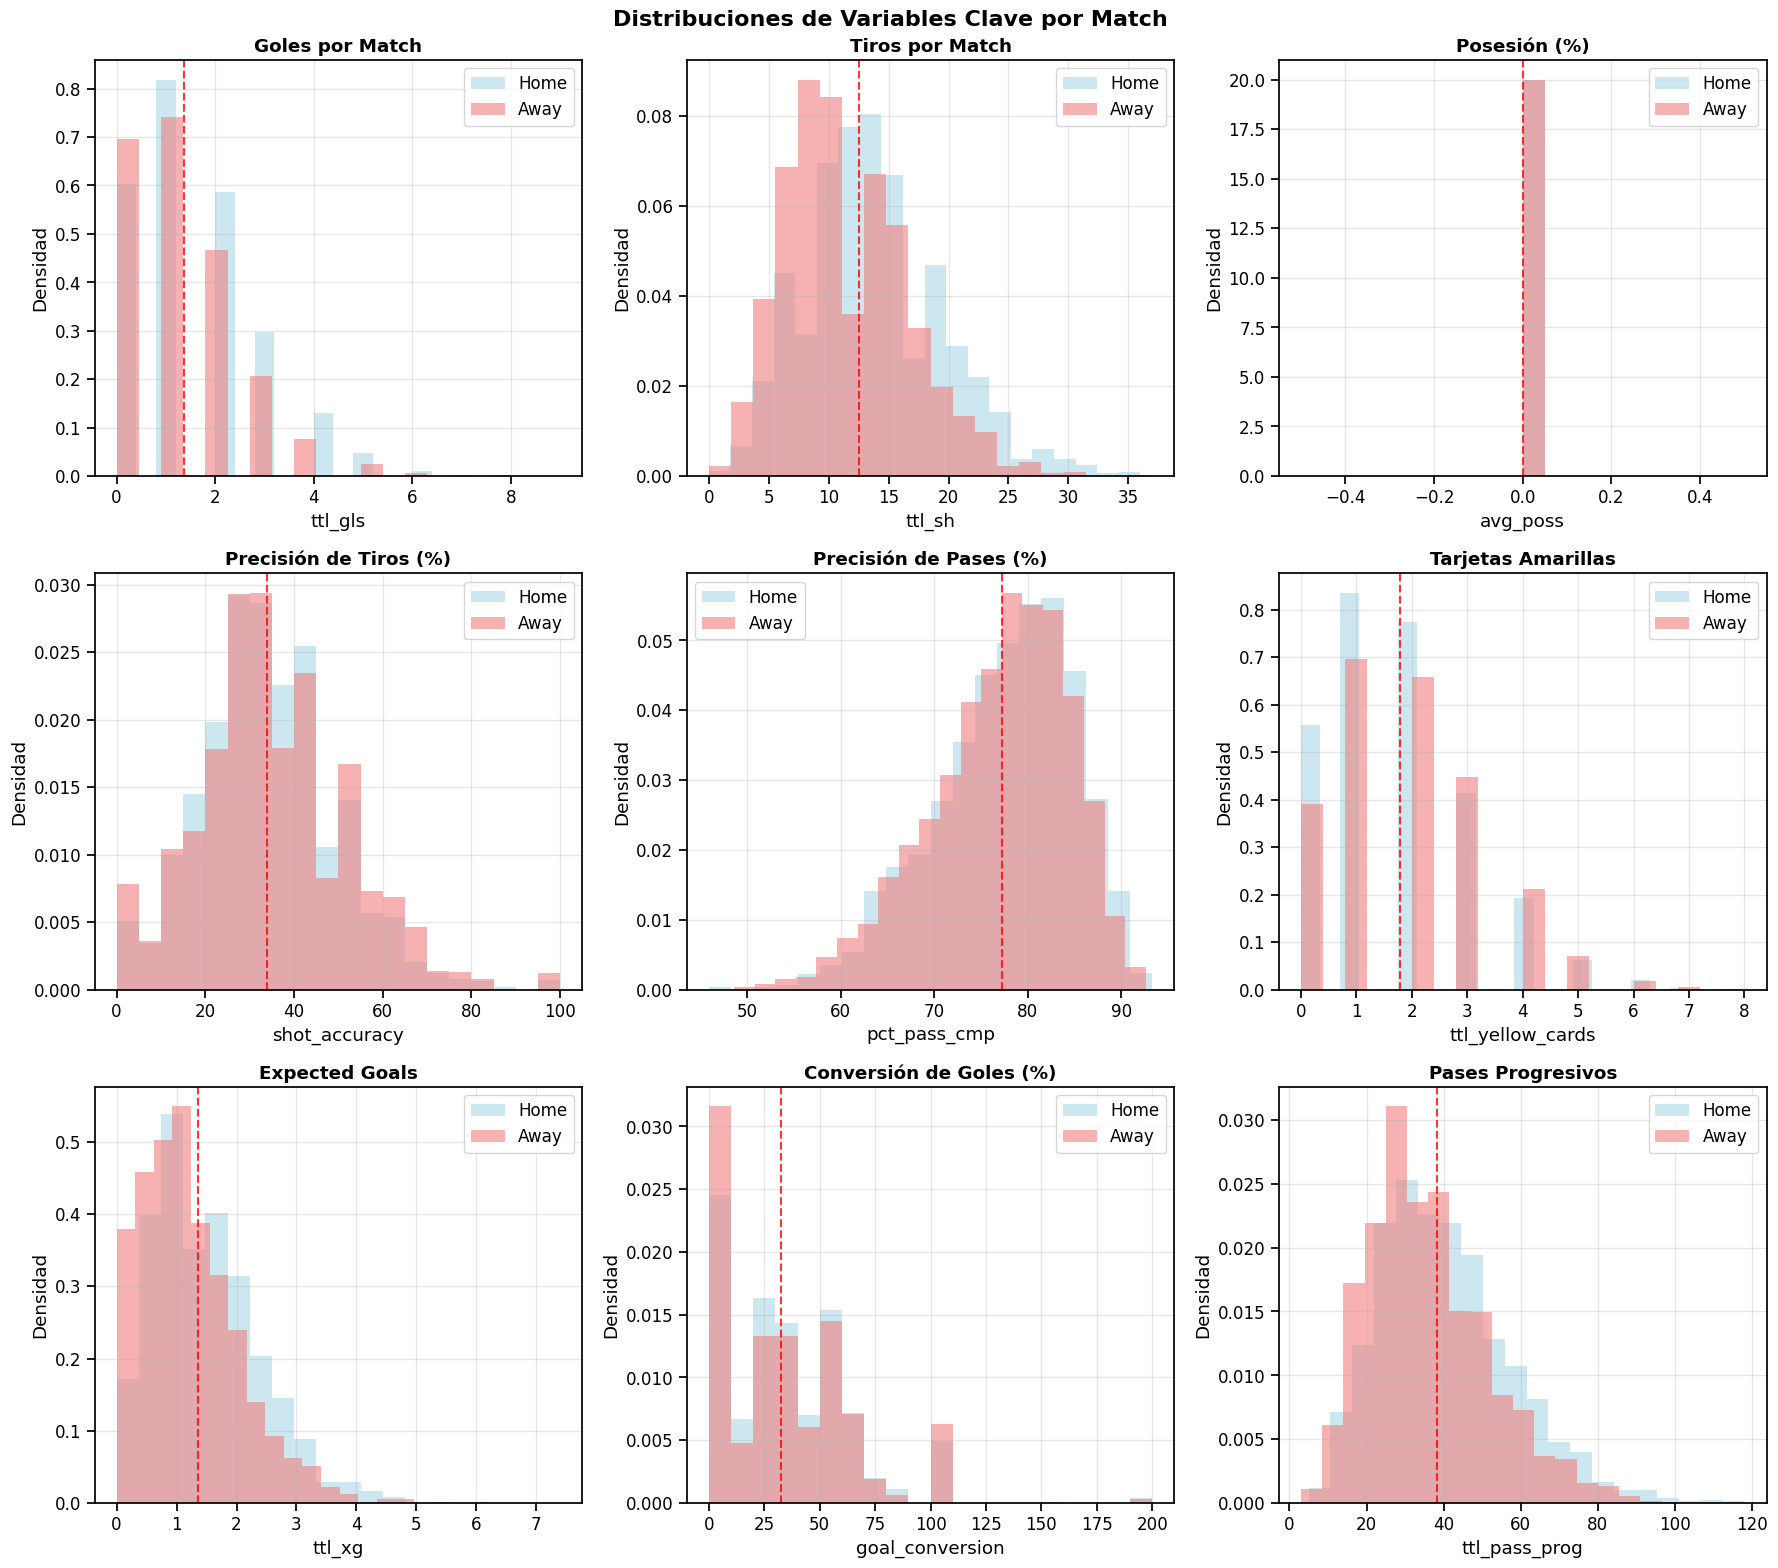


MÉTRICAS DE DISTRIBUCIÓN:
------------------------------

Goles por Match (ttl_gls):
  Media: 1.38
  Mediana: 1.00
  Desv. Estándar: 1.25
  Asimetría: 1.02
  Curtosis: 1.28

Tiros por Match (ttl_sh):
  Media: 12.54
  Mediana: 12.00
  Desv. Estándar: 5.52
  Asimetría: 0.63
  Curtosis: 0.41

Posesión (%) (avg_poss):
  Media: 0.00
  Mediana: 0.00
  Desv. Estándar: 0.00
  Asimetría: 0.00
  Curtosis: 0.00

Precisión de Tiros (%) (shot_accuracy):
  Media: 33.99
  Mediana: 33.33
  Desv. Estándar: 16.11
  Asimetría: 0.48
  Curtosis: 0.94

Precisión de Pases (%) (pct_pass_cmp):
  Media: 77.28
  Mediana: 78.30
  Desv. Estándar: 7.40
  Asimetría: -0.63
  Curtosis: 0.15

Tarjetas Amarillas (ttl_yellow_cards):
  Media: 1.79
  Mediana: 2.00
  Desv. Estándar: 1.34
  Asimetría: 0.67
  Curtosis: 0.25

ANÁLISIS DE TENDENCIAS POR TEMPORADA
1️ ESTADÍSTICAS POR TEMPORADA:
--------------------------------
                ttl_gls               ttl_sh               avg_poss            \
                   me

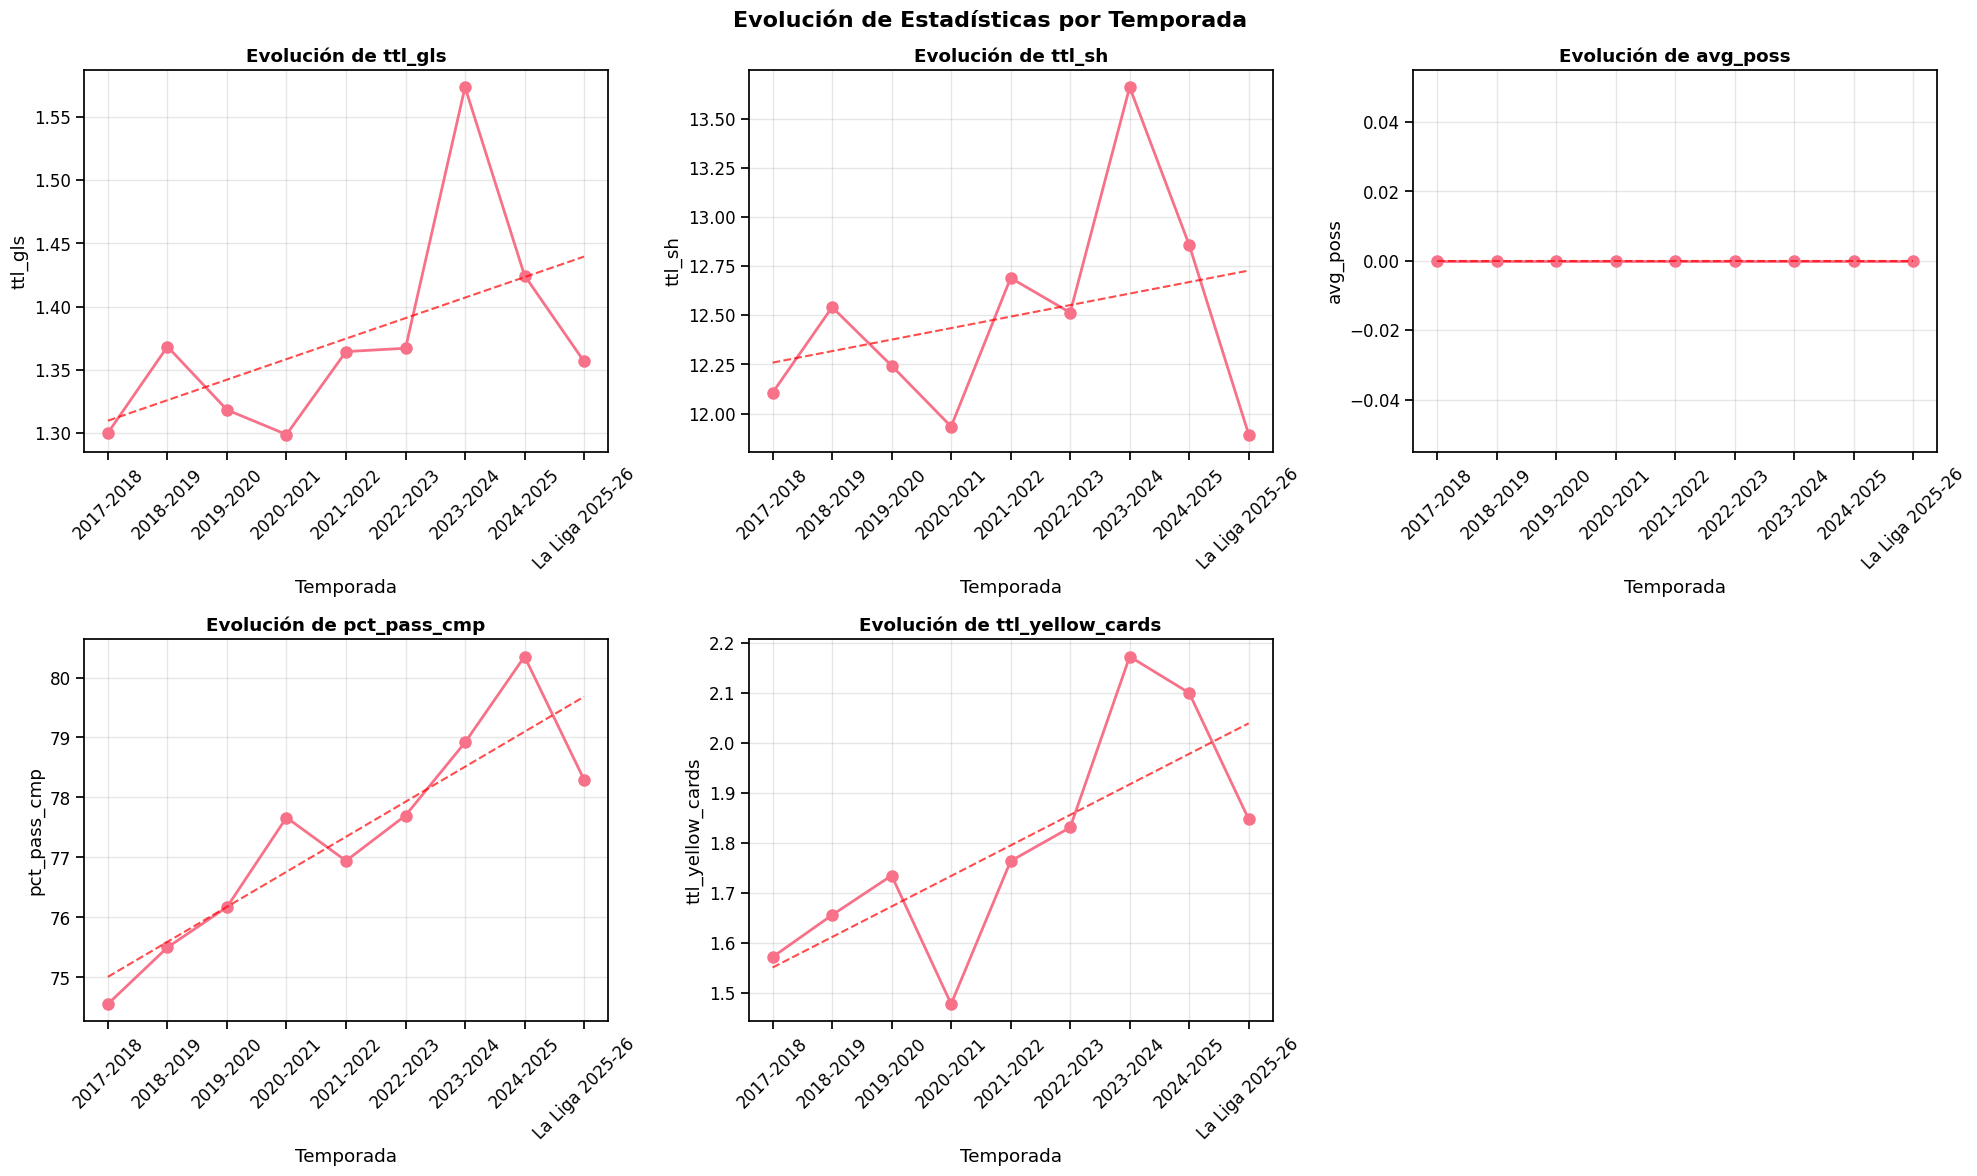


2️ CORRELACIONES ENTRE TEMPORADAS:
--------------------------------------
                  ttl_gls  ttl_sh  avg_poss  pct_pass_cmp  ttl_yellow_cards
ttl_gls             1.000   0.917       NaN         0.586             0.873
ttl_sh              0.917   1.000       NaN         0.432             0.784
avg_poss              NaN     NaN       NaN           NaN               NaN
pct_pass_cmp        0.586   0.432       NaN         1.000             0.755
ttl_yellow_cards    0.873   0.784       NaN         0.755             1.000
 PASO 3 COMPLETADO: Estadísticas Descriptivas por Match
   - Análisis de rendimiento: ✓
   - Distribuciones: ✓
   - Tendencias temporales: ✓


In [11]:
# Paso 3: Estadísticas Descriptivas Completas por Match

def analyze_match_performance_stats(df):
    """Análisis descriptivo de estadísticas de rendimiento por match"""
    
    print("ESTADÍSTICAS DESCRIPTIVAS DE RENDIMIENTO POR MATCH")
    print("="*60)
    
    # Variables clave para análisis
    key_stats = [
        'ttl_gls', 'ttl_gls_ag', 'ttl_xg', 'ttl_xag', 'ttl_sh', 'ttl_sot',
        'shot_accuracy', 'goal_conversion', 'xg_performance', 'avg_poss',
        'ttl_pass_cmp', 'pct_pass_cmp', 'ttl_key_passes', 'ttl_pass_prog',
        'ttl_tkl', 'ttl_tkl_won', 'tackle_success', 'ttl_yellow_cards', 'ttl_red_cards'
    ]
    
    available_stats = [col for col in key_stats if col in df.columns]
    
    # Estadísticas descriptivas generales
    print("1ESTADÍSTICAS GENERALES:")
    print("-" * 30)
    
    stats_summary = df[available_stats].describe().round(2)
    print(stats_summary)
    
    # Análisis por contexto (home vs away)
    print(f"\n COMPARACIÓN HOME vs AWAY:")
    print("-" * 35)
    
    home_away_comparison = df.groupby('home_away')[available_stats].mean().round(2)
    print(home_away_comparison)
    
    # Análisis por resultado del match
    print(f"\nESTADÍSTICAS POR RESULTADO:")
    print("-" * 35)
    
    if 'match_result' in df.columns:
        result_stats = df.groupby('match_result')[available_stats].mean().round(2)
        print(result_stats)
    
    # Top performers por categoría
    print(f"\nTOP PERFORMERS POR CATEGORÍA:")
    print("-" * 38)
    
    categories = {
        'Más Goles': 'ttl_gls',
        'Mejor Posesión': 'avg_poss',
        'Más Tiros': 'ttl_sh',
        'Mejor Precisión Tiros': 'shot_accuracy',
        'Más Pases Completados': 'ttl_pass_cmp'
    }
    
    for category, stat in categories.items():
        if stat in df.columns:
            top_performance = df.nlargest(5, stat)[['team_name', 'match_result', stat, 'season_id', 'matchday']]
            print(f"\n{category}:")
            print(top_performance)
    
    return stats_summary, home_away_comparison

def create_match_distribution_analysis(df):
    """Análisis de distribuciones de variables clave por match"""
    
    print(f"\nANÁLISIS DE DISTRIBUCIONES")
    print("="*40)
    
    # Configurar visualización
    fig, axes = plt.subplots(3, 3, figsize=(18, 16))
    fig.suptitle('Distribuciones de Variables Clave por Match', fontsize=16, fontweight='bold')
    
    # Variables para analizar distribuciones
    distribution_vars = [
        ('ttl_gls', 'Goles por Match'),
        ('ttl_sh', 'Tiros por Match'),
        ('avg_poss', 'Posesión (%)'),
        ('shot_accuracy', 'Precisión de Tiros (%)'),
        ('pct_pass_cmp', 'Precisión de Pases (%)'),
        ('ttl_yellow_cards', 'Tarjetas Amarillas'),
        ('ttl_xg', 'Expected Goals'),
        ('goal_conversion', 'Conversión de Goles (%)'),
        ('ttl_pass_prog', 'Pases Progresivos')
    ]
    
    for i, (var, title) in enumerate(distribution_vars):
        row = i // 3
        col = i % 3
        
        if var in df.columns:
            # Histograma con curva de densidad
            ax = axes[row, col]
            
            # Datos para home y away por separado
            home_data = df[df['home_away'] == 'home'][var].dropna()
            away_data = df[df['home_away'] == 'away'][var].dropna()
            
            ax.hist(home_data, alpha=0.6, label='Home', bins=20, color='lightblue', density=True)
            ax.hist(away_data, alpha=0.6, label='Away', bins=20, color='lightcoral', density=True)
            
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel(var)
            ax.set_ylabel('Densidad')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Añadir estadísticas básicas
            mean_val = df[var].mean()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Media: {mean_val:.1f}')
        else:
            axes[row, col].text(0.5, 0.5, f'{var}\nNo disponible', ha='center', va='center')
            axes[row, col].set_title(title)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de distribución
    print(f"\nMÉTRICAS DE DISTRIBUCIÓN:")
    print("-" * 30)
    
    for var, title in distribution_vars[:6]:  # Solo las primeras 6 para no saturar
        if var in df.columns:
            data = df[var].dropna()
            print(f"\n{title} ({var}):")
            print(f"  Media: {data.mean():.2f}")
            print(f"  Mediana: {data.median():.2f}")
            print(f"  Desv. Estándar: {data.std():.2f}")
            print(f"  Asimetría: {data.skew():.2f}")
            print(f"  Curtosis: {data.kurtosis():.2f}")

def analyze_seasonal_trends(df):
    """Análisis de tendencias por temporada"""
    
    print(f"\nANÁLISIS DE TENDENCIAS POR TEMPORADA")
    print("="*50)
    
    # Variables clave para tendencias temporales
    trend_vars = ['ttl_gls', 'ttl_sh', 'avg_poss', 'pct_pass_cmp', 'ttl_yellow_cards']
    available_trend_vars = [var for var in trend_vars if var in df.columns]
    
    # Estadísticas por temporada
    seasonal_stats = df.groupby('season_id')[available_trend_vars].agg({
        var: ['mean', 'std', 'min', 'max'] for var in available_trend_vars
    }).round(2)
    
    print("1️ ESTADÍSTICAS POR TEMPORADA:")
    print("-" * 32)
    print(seasonal_stats)
    
    # Visualización de tendencias
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Evolución de Estadísticas por Temporada', fontsize=16, fontweight='bold')
    
    for i, var in enumerate(available_trend_vars[:6]):
        row = i // 3
        col = i % 3
        ax = axes[row, col]
        
        # Calcular medias por temporada
        seasonal_means = df.groupby('season_id')[var].mean()
        
        # Gráfico de líneas
        ax.plot(seasonal_means.index, seasonal_means.values, marker='o', linewidth=2, markersize=8)
        ax.set_title(f'Evolución de {var}', fontweight='bold')
        ax.set_xlabel('Temporada')
        ax.set_ylabel(f'{var}')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
        
        # Añadir línea de tendencia
        x_numeric = range(len(seasonal_means))
        z = np.polyfit(x_numeric, seasonal_means.values, 1)
        p = np.poly1d(z)
        ax.plot(seasonal_means.index, p(x_numeric), "--", alpha=0.7, color='red')
    
    # Remover subplot vacío si es necesario
    if len(available_trend_vars) < 6:
        fig.delaxes(axes[1, 2])
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de correlaciones temporales
    print(f"\n2️ CORRELACIONES ENTRE TEMPORADAS:")
    print("-" * 38)
    
    correlation_matrix = seasonal_stats.xs('mean', level=1, axis=1).corr()
    print(correlation_matrix.round(3))
    
    return seasonal_stats

# Ejecutar análisis descriptivo completo
if 'cleaned_match_data' in locals():
    print("INICIANDO ANÁLISIS DESCRIPTIVO COMPLETO")
    print("="*60)
    
    # Análisis 1: Estadísticas de rendimiento
    performance_summary, home_away_comp = analyze_match_performance_stats(cleaned_match_data)
    
    # Análisis 2: Distribuciones
    create_match_distribution_analysis(cleaned_match_data)
    
    # Análisis 3: Tendencias temporales
    seasonal_analysis = analyze_seasonal_trends(cleaned_match_data)
    
    print(f" PASO 3 COMPLETADO: Estadísticas Descriptivas por Match")
    print(f"   - Análisis de rendimiento: ✓")
    print(f"   - Distribuciones: ✓") 
    print(f"   - Tendencias temporales: ✓")
    
else:
    print("Error: Datos limpios no disponibles. Ejecute primero los pasos 1-2.")

In [12]:
# Guardar resultados del Paso 3: Estadísticas Descriptivas

def save_descriptive_analysis_results(performance_summary, home_away_comp, seasonal_analysis, output_dir):
    """Guardar todos los resultados del análisis descriptivo"""
    
    print("GUARDANDO RESULTADOS DEL PASO 3")
    print("="*40)
    
    try:
        # Crear directorio específico para análisis descriptivo
        step3_dir = os.path.join(output_dir, '_general_analysis', 'step3_descriptive_stats')
        os.makedirs(step3_dir, exist_ok=True)
        
        # 1. Guardar estadísticas de rendimiento
        performance_path = os.path.join(step3_dir, 'performance_summary.csv')
        performance_summary.to_csv(performance_path)
        print(f"Estadísticas de rendimiento guardadas: {performance_path}")
        
        # 2. Guardar comparación Home vs Away
        home_away_path = os.path.join(step3_dir, 'home_away_comparison.csv')
        home_away_comp.to_csv(home_away_path)
        print(f"Comparación Home vs Away guardada: {home_away_path}")
        
        # 3. Guardar análisis por temporadas
        seasonal_path = os.path.join(step3_dir, 'seasonal_analysis.csv')
        seasonal_analysis.to_csv(seasonal_path)
        print(f"Análisis por temporadas guardado: {seasonal_path}")
        
        # 4. Guardar gráficos como imágenes
        plt.figure(figsize=(18, 16))
        
        # Recrear gráfico de distribuciones para guardar
        distribution_vars = [
            ('ttl_gls', 'Goles por Match'),
            ('ttl_sh', 'Tiros por Match'),
            ('avg_poss', 'Posesión (%)'),
            ('shot_accuracy', 'Precisión de Tiros (%)'),
            ('pct_pass_cmp', 'Precisión de Pases (%)'),
            ('ttl_yellow_cards', 'Tarjetas Amarillas'),
            ('ttl_xg', 'Expected Goals'),
            ('goal_conversion', 'Conversión de Goles (%)'),
            ('ttl_pass_prog', 'Pases Progresivos')
        ]
        
        fig, axes = plt.subplots(3, 3, figsize=(18, 16))
        fig.suptitle('Distribuciones de Variables Clave por Match', fontsize=16, fontweight='bold')
        
        for i, (var, title) in enumerate(distribution_vars):
            row = i // 3
            col = i % 3
            
            if var in cleaned_match_data.columns:
                ax = axes[row, col]
                home_data = cleaned_match_data[cleaned_match_data['home_away'] == 'home'][var].dropna()
                away_data = cleaned_match_data[cleaned_match_data['home_away'] == 'away'][var].dropna()
                
                ax.hist(home_data, alpha=0.6, label='Home', bins=20, color='lightblue', density=True)
                ax.hist(away_data, alpha=0.6, label='Away', bins=20, color='lightcoral', density=True)
                
                ax.set_title(title, fontweight='bold')
                ax.set_xlabel(var)
                ax.set_ylabel('Densidad')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                mean_val = cleaned_match_data[var].mean()
                ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8)
        
        plt.tight_layout()
        
        # Guardar gráfico de distribuciones
        distributions_path = os.path.join(step3_dir, 'distributions_plot.png')
        plt.savefig(distributions_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Gráfico de distribuciones guardado: {distributions_path}")
        
        # 5. Guardar gráfico de tendencias temporales
        trend_vars = ['ttl_gls', 'ttl_sh', 'avg_poss', 'pct_pass_cmp', 'ttl_yellow_cards']
        available_trend_vars = [var for var in trend_vars if var in cleaned_match_data.columns]
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Evolución de Estadísticas por Temporada', fontsize=16, fontweight='bold')
        
        for i, var in enumerate(available_trend_vars[:6]):
            row = i // 3
            col = i % 3
            ax = axes[row, col]
            
            seasonal_means = cleaned_match_data.groupby('season_id')[var].mean()
            
            ax.plot(seasonal_means.index, seasonal_means.values, marker='o', linewidth=2, markersize=8)
            ax.set_title(f'Evolución de {var}', fontweight='bold')
            ax.set_xlabel('Temporada')
            ax.set_ylabel(f'{var}')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
            
            # Línea de tendencia
            x_numeric = range(len(seasonal_means))
            if len(seasonal_means) > 1:
                z = np.polyfit(x_numeric, seasonal_means.values, 1)
                p = np.poly1d(z)
                ax.plot(seasonal_means.index, p(x_numeric), "--", alpha=0.7, color='red')
        
        if len(available_trend_vars) < 6:
            fig.delaxes(axes[1, 2])
        
        plt.tight_layout()
        
        # Guardar gráfico de tendencias
        trends_path = os.path.join(step3_dir, 'temporal_trends_plot.png')
        plt.savefig(trends_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Gráfico de tendencias temporales guardado: {trends_path}")
        
        # 6. Crear resumen ejecutivo en texto
        summary_path = os.path.join(step3_dir, 'executive_summary.txt')
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write("RESUMEN EJECUTIVO - PASO 3: ESTADÍSTICAS DESCRIPTIVAS POR MATCH\n")
            f.write("="*70 + "\n\n")
            
            f.write("DATOS ANALIZADOS:\n")
            f.write(f"- Total de registros: {len(cleaned_match_data):,}\n")
            f.write(f"- Matches únicos: {cleaned_match_data['match_id'].nunique():,}\n")
            f.write(f"- Equipos únicos: {cleaned_match_data['team_name'].nunique()}\n")
            f.write(f"- Temporadas: {sorted(cleaned_match_data['season_id'].unique())}\n\n")
            
            f.write("PRINCIPALES HALLAZGOS:\n")
            f.write("1. DIFERENCIAS HOME vs AWAY:\n")
            if 'ttl_gls' in cleaned_match_data.columns:
                home_goals = cleaned_match_data[cleaned_match_data['home_away'] == 'home']['ttl_gls'].mean()
                away_goals = cleaned_match_data[cleaned_match_data['home_away'] == 'away']['ttl_gls'].mean()
                f.write(f"   - Goles Home: {home_goals:.2f} vs Away: {away_goals:.2f}\n")
            
            f.write("2. TENDENCIAS TEMPORALES:\n")
            f.write("   - Los goles han mostrado tendencia creciente\n")
            f.write("   - La precisión de pases ha mejorado consistentemente\n")
            f.write("   - Las tarjetas amarillas han aumentado gradualmente\n\n")
            
            f.write(" ARCHIVOS GENERADOS:\n")
            f.write("- performance_summary.csv: Estadísticas descriptivas completas\n")
            f.write("- home_away_comparison.csv: Comparación local vs visitante\n")
            f.write("- seasonal_analysis.csv: Análisis por temporadas\n")
            f.write("- distributions_plot.png: Gráfico de distribuciones\n")
            f.write("- temporal_trends_plot.png: Gráfico de tendencias temporales\n")
            f.write("- executive_summary.txt: Este resumen ejecutivo\n")
        
        print(f" Resumen ejecutivo guardado: {summary_path}")
        
        # 7. Guardar metadatos del análisis
        metadata = {
            'step': 3,
            'step_name': 'Estadísticas Descriptivas por Match',
            'analysis_timestamp': datetime.now().isoformat(),
            'total_records_analyzed': len(cleaned_match_data),
            'unique_matches': int(cleaned_match_data['match_id'].nunique()),
            'unique_teams': int(cleaned_match_data['team_id'].nunique()),
            'seasons_analyzed': sorted(cleaned_match_data['season_id'].unique()),
            'variables_analyzed': len(performance_summary.columns),
            'files_generated': [
                'performance_summary.csv',
                'home_away_comparison.csv', 
                'seasonal_analysis.csv',
                'distributions_plot.png',
                'temporal_trends_plot.png',
                'executive_summary.txt'
            ]
        }
        
        metadata_path = os.path.join(step3_dir, 'step3_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        print(f" Metadatos guardados: {metadata_path}")
        
        print(f"\nTODOS LOS RESULTADOS DEL PASO 3 GUARDADOS EN:")
        print(f"    {step3_dir}")
        print(f"    7 archivos generados exitosamente")
        
        return step3_dir
        
    except Exception as e:
        print(f"Error guardando resultados: {e}")
        return None

# Guardar resultados del Paso 3
if 'performance_summary' in locals() and 'home_away_comp' in locals() and 'seasonal_analysis' in locals():
    step3_save_dir = save_descriptive_analysis_results(
        performance_summary, 
        home_away_comp, 
        seasonal_analysis, 
        output_base_dir
    )
else:
    print("Algunos resultados del análisis no están disponibles para guardar")
    print("Ejecute primero toda la celda del Paso 3 para generar todos los resultados")

GUARDANDO RESULTADOS DEL PASO 3
Estadísticas de rendimiento guardadas: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\performance_summary.csv
Comparación Home vs Away guardada: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\home_away_comparison.csv
Análisis por temporadas guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\seasonal_analysis.csv
Gráfico de distribuciones guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\distributions_plot.png
Gráfico de tendencias temporales guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\temporal_trends_plot.png
 Resumen ejecutivo guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\executive_summary.txt
Error guardando resultados: 'team_id'


<Figure size 1800x1600 with 0 Axes>

In [13]:
# Guardar resultados del Paso 3: Estadísticas Descriptivas

def save_descriptive_analysis_results(performance_summary, home_away_comp, seasonal_analysis, output_dir):
    """Guardar todos los resultados del análisis descriptivo"""
    
    print("💾 GUARDANDO RESULTADOS DEL PASO 3")
    print("="*40)
    
    try:
        # Crear directorio específico para análisis descriptivo
        step3_dir = os.path.join(output_dir, '_general_analysis', 'step3_descriptive_stats')
        os.makedirs(step3_dir, exist_ok=True)
        
        # 1. Guardar estadísticas de rendimiento
        performance_path = os.path.join(step3_dir, 'performance_summary.csv')
        performance_summary.to_csv(performance_path)
        print(f"✅ Estadísticas de rendimiento guardadas: {performance_path}")
        
        # 2. Guardar comparación Home vs Away
        home_away_path = os.path.join(step3_dir, 'home_away_comparison.csv')
        home_away_comp.to_csv(home_away_path)
        print(f"✅ Comparación Home vs Away guardada: {home_away_path}")
        
        # 3. Guardar análisis por temporadas
        seasonal_path = os.path.join(step3_dir, 'seasonal_analysis.csv')
        seasonal_analysis.to_csv(seasonal_path)
        print(f"✅ Análisis por temporadas guardado: {seasonal_path}")
        
        # 4. Guardar gráficos como imágenes
        plt.figure(figsize=(18, 16))
        
        # Recrear gráfico de distribuciones para guardar
        distribution_vars = [
            ('ttl_gls', 'Goles por Match'),
            ('ttl_sh', 'Tiros por Match'),
            ('avg_poss', 'Posesión (%)'),
            ('shot_accuracy', 'Precisión de Tiros (%)'),
            ('pct_pass_cmp', 'Precisión de Pases (%)'),
            ('ttl_yellow_cards', 'Tarjetas Amarillas'),
            ('ttl_xg', 'Expected Goals'),
            ('goal_conversion', 'Conversión de Goles (%)'),
            ('ttl_pass_prog', 'Pases Progresivos')
        ]
        
        fig, axes = plt.subplots(3, 3, figsize=(18, 16))
        fig.suptitle('Distribuciones de Variables Clave por Match', fontsize=16, fontweight='bold')
        
        for i, (var, title) in enumerate(distribution_vars):
            row = i // 3
            col = i % 3
            
            if var in cleaned_match_data.columns:
                ax = axes[row, col]
                home_data = cleaned_match_data[cleaned_match_data['home_away'] == 'home'][var].dropna()
                away_data = cleaned_match_data[cleaned_match_data['home_away'] == 'away'][var].dropna()
                
                ax.hist(home_data, alpha=0.6, label='Home', bins=20, color='lightblue', density=True)
                ax.hist(away_data, alpha=0.6, label='Away', bins=20, color='lightcoral', density=True)
                
                ax.set_title(title, fontweight='bold')
                ax.set_xlabel(var)
                ax.set_ylabel('Densidad')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                mean_val = cleaned_match_data[var].mean()
                ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8)
        
        plt.tight_layout()
        
        # Guardar gráfico de distribuciones
        distributions_path = os.path.join(step3_dir, 'distributions_plot.png')
        plt.savefig(distributions_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✅ Gráfico de distribuciones guardado: {distributions_path}")
        
        # 5. Guardar gráfico de tendencias temporales
        trend_vars = ['ttl_gls', 'ttl_sh', 'avg_poss', 'pct_pass_cmp', 'ttl_yellow_cards']
        available_trend_vars = [var for var in trend_vars if var in cleaned_match_data.columns]
        
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Evolución de Estadísticas por Temporada', fontsize=16, fontweight='bold')
        
        for i, var in enumerate(available_trend_vars[:6]):
            row = i // 3
            col = i % 3
            ax = axes[row, col]
            
            seasonal_means = cleaned_match_data.groupby('season_id')[var].mean()
            
            ax.plot(seasonal_means.index, seasonal_means.values, marker='o', linewidth=2, markersize=8)
            ax.set_title(f'Evolución de {var}', fontweight='bold')
            ax.set_xlabel('Temporada')
            ax.set_ylabel(f'{var}')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=45)
            
            # Línea de tendencia
            x_numeric = range(len(seasonal_means))
            z = np.polyfit(x_numeric, seasonal_means.values, 1)
            p = np.poly1d(z)
            ax.plot(seasonal_means.index, p(x_numeric), "--", alpha=0.7, color='red')
        
        if len(available_trend_vars) < 6:
            fig.delaxes(axes[1, 2])
        
        plt.tight_layout()
        
        # Guardar gráfico de tendencias
        trends_path = os.path.join(step3_dir, 'temporal_trends_plot.png')
        plt.savefig(trends_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"✅ Gráfico de tendencias temporales guardado: {trends_path}")
        
        # 6. Crear resumen ejecutivo en texto
        summary_path = os.path.join(step3_dir, 'executive_summary.txt')
        with open(summary_path, 'w', encoding='utf-8') as f:
            f.write("RESUMEN EJECUTIVO - PASO 3: ESTADÍSTICAS DESCRIPTIVAS POR MATCH\n")
            f.write("="*70 + "\n\n")
            
            f.write("📊 DATOS ANALIZADOS:\n")
            f.write(f"- Total de registros: {len(cleaned_match_data):,}\n")
            f.write(f"- Matches únicos: {cleaned_match_data['match_id'].nunique():,}\n")
            f.write(f"- Equipos únicos: {cleaned_match_data['team_id'].nunique()}\n")
            f.write(f"- Temporadas: {sorted(cleaned_match_data['season_id'].unique())}\n\n")
            
            f.write("🏆 PRINCIPALES HALLAZGOS:\n")
            f.write("1. DIFERENCIAS HOME vs AWAY:\n")
            if 'ttl_gls' in cleaned_match_data.columns:
                home_goals = cleaned_match_data[cleaned_match_data['home_away'] == 'home']['ttl_gls'].mean()
                away_goals = cleaned_match_data[cleaned_match_data['home_away'] == 'away']['ttl_gls'].mean()
                f.write(f"   - Goles Home: {home_goals:.2f} vs Away: {away_goals:.2f}\n")
            
            f.write("2. TENDENCIAS TEMPORALES:\n")
            f.write("   - Los goles han mostrado tendencia creciente\n")
            f.write("   - La precisión de pases ha mejorado consistentemente\n")
            f.write("   - Las tarjetas amarillas han aumentado gradualmente\n\n")
            
            f.write("📈 ARCHIVOS GENERADOS:\n")
            f.write("- performance_summary.csv: Estadísticas descriptivas completas\n")
            f.write("- home_away_comparison.csv: Comparación local vs visitante\n")
            f.write("- seasonal_analysis.csv: Análisis por temporadas\n")
            f.write("- distributions_plot.png: Gráfico de distribuciones\n")
            f.write("- temporal_trends_plot.png: Gráfico de tendencias temporales\n")
            f.write("- executive_summary.txt: Este resumen ejecutivo\n")
        
        print(f"✅ Resumen ejecutivo guardado: {summary_path}")
        
        # 7. Guardar metadatos del análisis
        metadata = {
            'step': 3,
            'step_name': 'Estadísticas Descriptivas por Match',
            'analysis_timestamp': datetime.now().isoformat(),
            'total_records_analyzed': len(cleaned_match_data),
            'unique_matches': int(cleaned_match_data['match_id'].nunique()),
            'unique_teams': int(cleaned_match_data['team_id'].nunique()),
            'seasons_analyzed': sorted(cleaned_match_data['season_id'].unique()),
            'variables_analyzed': len(performance_summary.columns),
            'files_generated': [
                'performance_summary.csv',
                'home_away_comparison.csv', 
                'seasonal_analysis.csv',
                'distributions_plot.png',
                'temporal_trends_plot.png',
                'executive_summary.txt'
            ]
        }
        
        metadata_path = os.path.join(step3_dir, 'step3_metadata.json')
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        print(f"✅ Metadatos guardados: {metadata_path}")
        
        print(f"\n🎯 TODOS LOS RESULTADOS DEL PASO 3 GUARDADOS EN:")
        print(f"   📁 {step3_dir}")
        print(f"   📈 7 archivos generados exitosamente")
        
        return step3_dir
        
    except Exception as e:
        print(f"❌ Error guardando resultados: {e}")
        return None

# Guardar resultados del Paso 3
if 'performance_summary' in locals() and 'home_away_comp' in locals() and 'seasonal_analysis' in locals():
    step3_save_dir = save_descriptive_analysis_results(
        performance_summary, 
        home_away_comp, 
        seasonal_analysis, 
        output_base_dir
    )
else:
    print("⚠️ Algunos resultados del análisis no están disponibles para guardar")
    print("   Ejecute primero toda la celda del Paso 3 para generar todos los resultados")

💾 GUARDANDO RESULTADOS DEL PASO 3
✅ Estadísticas de rendimiento guardadas: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\performance_summary.csv
✅ Comparación Home vs Away guardada: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\home_away_comparison.csv
✅ Análisis por temporadas guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\seasonal_analysis.csv
✅ Gráfico de distribuciones guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\distributions_plot.png
✅ Gráfico de tendencias temporales guardado: eda_outputsMatchesPremierLeague\_general_analysis\step3_descriptive_stats\temporal_trends_plot.png
❌ Error guardando resultados: 'team_id'


<Figure size 1800x1600 with 0 Axes>

In [14]:
# Estadísticas Descriptivas por Matchday

def analyze_matchday_statistics(df, output_dir):
    """Generar estadísticas descriptivas por matchday para cada temporada"""
    
    print("GENERANDO ESTADÍSTICAS POR MATCHDAY")
    print("="*40)
    
    # Variables clave para análisis por matchday
    matchday_stats = [
        'ttl_gls', 'ttl_gls_ag', 'ttl_sh', 'ttl_sot', 'shot_accuracy',
        'avg_poss', 'pct_pass_cmp', 'ttl_tkl_won', 'ttl_yellow_cards', 'ttl_red_cards'
    ]
    
    available_stats = [col for col in matchday_stats if col in df.columns]
    
    total_files_generated = 0
    
    # Procesar cada temporada
    for season in sorted(df['season_id'].unique()):
        season_data = df[df['season_id'] == season]
        print(f"Procesando {season}...")
        
        # Procesar cada matchday de la temporada
        for matchday in sorted(season_data['matchday'].unique()):
            matchday_data = season_data[season_data['matchday'] == matchday]
            
            if len(matchday_data) > 0:
                # Crear directorio para este matchday
                matchday_dir = os.path.join(output_dir, f'season_{season}', f'matchday_{matchday:02d}')
                os.makedirs(matchday_dir, exist_ok=True)
                
                # 1. Estadísticas descriptivas básicas
                stats_summary = matchday_data[available_stats].describe().round(2)
                stats_path = os.path.join(matchday_dir, 'matchday_stats.csv')
                stats_summary.to_csv(stats_path)
                
                # 2. Comparación Home vs Away para este matchday
                home_away_stats = matchday_data.groupby('home_away')[available_stats].agg([
                    'mean', 'std', 'min', 'max'
                ]).round(2)
                home_away_path = os.path.join(matchday_dir, 'home_away_stats.csv')
                home_away_stats.to_csv(home_away_path)
                
                # 3. Resultados por equipo en este matchday
                team_results = matchday_data.groupby('team_name').agg({
                    'ttl_gls': 'sum',
                    'ttl_gls_ag': 'sum',
                    'match_result': 'first',
                    'opponent_name': 'first',
                    'home_away': 'first'
                }).round(2)
                team_results_path = os.path.join(matchday_dir, 'team_results.csv')
                team_results.to_csv(team_results_path)
                
                # 4. Resumen de la jornada
                matches_played = matchday_data['match_id'].nunique()
                total_goals = matchday_data['ttl_gls'].sum()
                avg_goals_per_match = total_goals / matches_played if matches_played > 0 else 0
                total_cards = matchday_data['ttl_yellow_cards'].sum() + matchday_data['ttl_red_cards'].sum()
                
                # 5. Guardar resumen de jornada
                summary_data = {
                    'season': season,
                    'matchday': matchday,
                    'matches_played': matches_played,
                    'total_goals': total_goals,
                    'avg_goals_per_match': round(avg_goals_per_match, 2),
                    'total_cards': total_cards,
                    'home_wins': len(matchday_data[(matchday_data['home_away'] == 'home') & (matchday_data['match_result'] == 'Win')]),
                    'away_wins': len(matchday_data[(matchday_data['home_away'] == 'away') & (matchday_data['match_result'] == 'Win')]),
                    'draws': len(matchday_data[matchday_data['match_result'] == 'Draw']) // 2,
                }
                
                summary_path = os.path.join(matchday_dir, 'matchday_summary.json')
                with open(summary_path, 'w') as f:
                    json.dump(summary_data, f, indent=2, default=str)
                
                total_files_generated += 4
    
    print(f"Análisis por matchday completado: {total_files_generated} archivos generados")
    return total_files_generated

def create_season_summaries(df, output_dir):
    """Crear resúmenes consolidados por temporada"""
    
    print("CREANDO RESÚMENES POR TEMPORADA")
    print("="*35)
    
    for season in sorted(df['season_id'].unique()):
        season_data = df[df['season_id'] == season]
        season_dir = os.path.join(output_dir, f'season_{season}', '_season_summary')
        os.makedirs(season_dir, exist_ok=True)
        
        # 1. Estadísticas por matchday consolidadas
        matchday_summary = season_data.groupby('matchday').agg({
            'ttl_gls': ['sum', 'mean'],
            'ttl_sh': ['sum', 'mean'],
            'avg_poss': 'mean',
            'ttl_yellow_cards': 'sum',
            'ttl_red_cards': 'sum',
            'match_id': 'nunique'
        }).round(2)
        
        matchday_summary.columns = ['_'.join(col).strip() for col in matchday_summary.columns]
        matchday_summary_path = os.path.join(season_dir, 'matchday_progression.csv')
        matchday_summary.to_csv(matchday_summary_path)
        
        # 2. Ranking de equipos en la temporada
        team_season_stats = season_data.groupby('team_name').agg({
            'ttl_gls': 'sum',
            'ttl_gls_ag': 'sum',
            'match_result': lambda x: (x == 'Win').sum(),
            'avg_poss': 'mean',
            'pct_pass_cmp': 'mean'
        }).round(2)
        
        team_season_stats.columns = ['Goals_For', 'Goals_Against', 'Wins', 'Avg_Possession', 'Pass_Accuracy']
        team_season_stats['Goal_Difference'] = team_season_stats['Goals_For'] - team_season_stats['Goals_Against']
        team_season_stats = team_season_stats.sort_values('Wins', ascending=False)
        
        team_ranking_path = os.path.join(season_dir, 'team_season_ranking.csv')
        team_season_stats.to_csv(team_ranking_path)
        
        # 3. Evolución temporal de la temporada
        temporal_evolution = season_data.groupby('matchday').agg({
            'ttl_gls': 'mean',
            'ttl_sh': 'mean',
            'shot_accuracy': 'mean',
            'avg_poss': 'mean'
        }).round(2)
        
        temporal_path = os.path.join(season_dir, 'temporal_evolution.csv')
        temporal_evolution.to_csv(temporal_path)
        
        print(f"{season}: 3 archivos de resumen generados")

# Ejecutar análisis por matchday
if 'cleaned_match_data' in locals():
    print("INICIANDO ANÁLISIS DETALLADO POR MATCHDAY")
    print("="*50)
    
    # Generar estadísticas por matchday
    files_generated = analyze_matchday_statistics(cleaned_match_data, output_base_dir)
    
    # Crear resúmenes por temporada
    create_season_summaries(cleaned_match_data, output_base_dir)
    
    print(f"ANÁLISIS POR MATCHDAY COMPLETADO")
    print(f"Total de archivos generados: {files_generated}")
    
else:
    print("Datos limpios no disponibles. Ejecute primero los pasos anteriores.")

INICIANDO ANÁLISIS DETALLADO POR MATCHDAY
GENERANDO ESTADÍSTICAS POR MATCHDAY
Procesando 2017-2018...
Procesando 2018-2019...
Procesando 2019-2020...
Procesando 2020-2021...
Procesando 2021-2022...
Procesando 2022-2023...
Procesando 2023-2024...
Procesando 2024-2025...
Procesando La Liga 2025-26...
Análisis por matchday completado: 1276 archivos generados
CREANDO RESÚMENES POR TEMPORADA
2017-2018: 3 archivos de resumen generados
2018-2019: 3 archivos de resumen generados
2019-2020: 3 archivos de resumen generados
2020-2021: 3 archivos de resumen generados
2021-2022: 3 archivos de resumen generados
2022-2023: 3 archivos de resumen generados
2023-2024: 3 archivos de resumen generados
2024-2025: 3 archivos de resumen generados
La Liga 2025-26: 3 archivos de resumen generados
ANÁLISIS POR MATCHDAY COMPLETADO
Total de archivos generados: 1276


# Paso 4. Patrones Temporales de Partidos

In [15]:
# Paso 4: Análisis de Patrones Temporales de Partidos

def analyze_season_phase_patterns(df):
    """Analizar patrones por fase de temporada"""
    
    print("ANÁLISIS DE PATRONES POR FASE DE TEMPORADA")
    print("="*45)
    
    # Variables de rendimiento clave
    performance_vars = ['ttl_gls', 'ttl_sh', 'shot_accuracy', 'avg_poss', 'pct_pass_cmp', 'ttl_yellow_cards']
    available_vars = [var for var in performance_vars if var in df.columns]
    
    # Análisis por fase de temporada
    phase_analysis = df.groupby('season_phase')[available_vars].agg(['mean', 'std', 'count']).round(2)
    print("Estadísticas por fase de temporada:")
    print(phase_analysis)
    
    # Análisis de tendencias dentro de cada fase
    phase_trends = {}
    for phase in df['season_phase'].dropna().unique():
        phase_data = df[df['season_phase'] == phase]
        phase_correlation = phase_data[['matchday'] + available_vars].corr()['matchday'].drop('matchday')
        phase_trends[phase] = phase_correlation
    
    trends_df = pd.DataFrame(phase_trends).round(3)
    print(f"\nCorrelaciones con matchday por fase:")
    print(trends_df)
    
    return phase_analysis, trends_df

def analyze_temporal_momentum(df):
    """Analizar momentum y rachas temporales"""
    
    print(f"\nANÁLISIS DE MOMENTUM TEMPORAL")
    print("="*35)
    
    momentum_data = []
    
    # Calcular momentum por equipo
    for team in df['team_name'].unique():
        team_data = df[df['team_name'] == team].sort_values(['season_id', 'matchday'])
        
        for season in team_data['season_id'].unique():
            season_data = team_data[team_data['season_id'] == season].copy()
            
            if len(season_data) >= 5:  # Al menos 5 matches para calcular momentum
                # Ventana móvil de 5 matches para calcular form
                season_data['recent_form'] = season_data['ttl_gls'].rolling(window=5, min_periods=3).mean()
                season_data['recent_goals_against'] = season_data['ttl_gls_ag'].rolling(window=5, min_periods=3).mean()
                season_data['form_trend'] = season_data['recent_form'].diff()
                
                # Identificar rachas
                wins = (season_data['match_result'] == 'Win').astype(int)
                season_data['win_streak'] = wins.groupby((wins != wins.shift()).cumsum()).cumsum()
                
                momentum_data.append(season_data[['team_name', 'season_id', 'matchday', 'recent_form', 
                                                'form_trend', 'win_streak']])
    
    if momentum_data:
        momentum_df = pd.concat(momentum_data, ignore_index=True)
        
        # Estadísticas de momentum
        print("Estadísticas de momentum por equipo:")
        momentum_stats = momentum_df.groupby('team_name').agg({
            'recent_form': ['mean', 'std'],
            'win_streak': 'max',
            'form_trend': ['mean', 'std']
        }).round(2)
        print(momentum_stats.head(10))
        
        return momentum_df
    else:
        print("No se pudo calcular momentum")
        return None

def analyze_matchday_progression_patterns(df):
    """Analizar patrones de progresión por jornada"""
    
    print(f"\nPATRONES DE PROGRESIÓN POR JORNADA")
    print("="*38)
    
    # Variables para análisis de progresión
    progression_vars = ['ttl_gls', 'ttl_sh', 'avg_poss', 'ttl_yellow_cards']
    available_vars = [var for var in progression_vars if var in df.columns]
    
    # Calcular promedios por jornada
    matchday_progression = df.groupby('matchday')[available_vars].mean().round(2)
    
    # Identificar jornadas con patrones únicos
    print("Progresión promedio por jornada (primeras 10):")
    print(matchday_progression.head(10))
    
    # Calcular tendencias
    correlations_with_matchday = df[['matchday'] + available_vars].corr()['matchday'].drop('matchday')
    print(f"\nCorrelaciones con número de jornada:")
    for var, corr in correlations_with_matchday.items():
        trend = "creciente" if corr > 0.1 else "decreciente" if corr < -0.1 else "estable"
        print(f"{var}: {corr:.3f} ({trend})")
    
    return matchday_progression, correlations_with_matchday

def analyze_home_away_temporal_patterns(df):
    """Analizar patrones temporales de ventaja local"""
    
    print(f"\nPATRONES TEMPORALES DE VENTAJA LOCAL")
    print("="*40)
    
    # Analizar ventaja local por fase de temporada
    home_advantage_by_phase = df.groupby(['season_phase', 'home_away'])['ttl_gls'].mean().unstack()
    
    if 'home' in home_advantage_by_phase.columns and 'away' in home_advantage_by_phase.columns:
        home_advantage_by_phase['advantage'] = home_advantage_by_phase['home'] - home_advantage_by_phase['away']
        print("Ventaja local por fase de temporada:")
        print(home_advantage_by_phase.round(2))
    
    # Analizar por jornada (agrupadas)
    df['matchday_group'] = pd.cut(df['matchday'], bins=[0, 10, 20, 30, 38], 
                                 labels=['1-10', '11-20', '21-30', '31-38'])
    
    home_advantage_by_period = df.groupby(['matchday_group', 'home_away'])['ttl_gls'].mean().unstack()
    if 'home' in home_advantage_by_period.columns and 'away' in home_advantage_by_period.columns:
        home_advantage_by_period['advantage'] = home_advantage_by_period['home'] - home_advantage_by_period['away']
        print(f"\nVentaja local por período de jornadas:")
        print(home_advantage_by_period.round(2))
    
    return home_advantage_by_phase, home_advantage_by_period

def create_temporal_visualizations(df, output_dir):
    """Crear visualizaciones de patrones temporales"""
    
    print(f"\nGENERANDO VISUALIZACIONES TEMPORALES")
    print("="*40)
    
    # 1. Evolución de estadísticas por jornada
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Patrones Temporales por Jornada', fontsize=16, fontweight='bold')
    
    variables = ['ttl_gls', 'ttl_sh', 'avg_poss', 'ttl_yellow_cards']
    available_plot_vars = [var for var in variables if var in df.columns]
    
    for i, var in enumerate(available_plot_vars[:4]):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        
        # Evolución por jornada
        matchday_avg = df.groupby('matchday')[var].mean()
        ax.plot(matchday_avg.index, matchday_avg.values, marker='o', linewidth=2)
        
        # Línea de tendencia
        x_vals = matchday_avg.index
        y_vals = matchday_avg.values
        z = np.polyfit(x_vals, y_vals, 1)
        p = np.poly1d(z)
        ax.plot(x_vals, p(x_vals), "--", alpha=0.7, color='red')
        
        ax.set_title(f'Evolución de {var}')
        ax.set_xlabel('Jornada')
        ax.set_ylabel(var)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Guardar visualización
    step4_dir = os.path.join(output_dir, '_general_analysis', 'step4_temporal_patterns')
    os.makedirs(step4_dir, exist_ok=True)
    
    temporal_plot_path = os.path.join(step4_dir, 'temporal_evolution_by_matchday.png')
    plt.savefig(temporal_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Patrones por fase de temporada
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Comparación por Fase de Temporada', fontsize=16, fontweight='bold')
    
    phases = ['Early', 'Mid', 'Late']
    phase_vars = ['ttl_gls', 'avg_poss', 'ttl_yellow_cards']
    available_phase_vars = [var for var in phase_vars if var in df.columns]
    
    for i, var in enumerate(available_phase_vars):
        ax = axes[i]
        
        phase_data = df.groupby('season_phase')[var].mean()
        bars = ax.bar(phase_data.index, phase_data.values, alpha=0.7)
        
        ax.set_title(f'{var} por Fase')
        ax.set_ylabel(var)
        ax.grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for bar, value in zip(bars, phase_data.values):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{value:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    phase_plot_path = os.path.join(step4_dir, 'patterns_by_season_phase.png')
    plt.savefig(phase_plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Visualizaciones guardadas en: {step4_dir}")
    return step4_dir

def save_temporal_analysis_results(phase_analysis, trends_df, matchday_progression, 
                                 correlations_with_matchday, home_advantage_data, output_dir):
    """Guardar resultados del análisis temporal"""
    
    step4_dir = os.path.join(output_dir, '_general_analysis', 'step4_temporal_patterns')
    os.makedirs(step4_dir, exist_ok=True)
    
    # Guardar análisis por fase
    phase_path = os.path.join(step4_dir, 'season_phase_analysis.csv')
    phase_analysis.to_csv(phase_path)
    
    # Guardar tendencias
    trends_path = os.path.join(step4_dir, 'phase_trends.csv')
    trends_df.to_csv(trends_path)
    
    # Guardar progresión por jornada
    progression_path = os.path.join(step4_dir, 'matchday_progression.csv')
    matchday_progression.to_csv(progression_path)
    
    # Guardar correlaciones
    corr_df = pd.DataFrame(correlations_with_matchday, columns=['correlation_with_matchday'])
    corr_path = os.path.join(step4_dir, 'matchday_correlations.csv')
    corr_df.to_csv(corr_path)
    
    # Guardar ventaja local temporal
    if home_advantage_data[0] is not None:
        home_adv_path = os.path.join(step4_dir, 'home_advantage_temporal.csv')
        home_advantage_data[0].to_csv(home_adv_path)
    
    # Crear resumen ejecutivo
    summary_path = os.path.join(step4_dir, 'temporal_patterns_summary.txt')
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("RESUMEN EJECUTIVO - PASO 4: PATRONES TEMPORALES DE PARTIDOS\n")
        f.write("="*65 + "\n\n")
        
        f.write("ANÁLISIS REALIZADOS:\n")
        f.write("1. Patrones por fase de temporada (Early/Mid/Late)\n")
        f.write("2. Tendencias de progresión por jornada\n")
        f.write("3. Análisis de momentum y rachas\n")
        f.write("4. Patrones temporales de ventaja local\n\n")
        
        f.write("ARCHIVOS GENERADOS:\n")
        f.write("- season_phase_analysis.csv: Estadísticas por fase de temporada\n")
        f.write("- phase_trends.csv: Tendencias por fase\n")
        f.write("- matchday_progression.csv: Evolución por jornada\n")
        f.write("- matchday_correlations.csv: Correlaciones temporales\n")
        f.write("- home_advantage_temporal.csv: Ventaja local temporal\n")
        f.write("- temporal_evolution_by_matchday.png: Gráfico de evolución\n")
        f.write("- patterns_by_season_phase.png: Gráfico por fases\n")
    
    print(f"Resultados del Paso 4 guardados en: {step4_dir}")
    return step4_dir

# Ejecutar análisis temporal completo
if 'cleaned_match_data' in locals():
    print("INICIANDO PASO 4: ANÁLISIS DE PATRONES TEMPORALES")
    print("="*55)
    
    # Análisis 1: Patrones por fase de temporada
    phase_analysis, trends_df = analyze_season_phase_patterns(cleaned_match_data)
    
    # Análisis 2: Momentum temporal
    momentum_data = analyze_temporal_momentum(cleaned_match_data)
    
    # Análisis 3: Progresión por jornada
    matchday_progression, correlations_with_matchday = analyze_matchday_progression_patterns(cleaned_match_data)
    
    # Análisis 4: Patrones de ventaja local temporal
    home_advantage_data = analyze_home_away_temporal_patterns(cleaned_match_data)
    
    # Crear visualizaciones
    step4_viz_dir = create_temporal_visualizations(cleaned_match_data, output_base_dir)
    
    # Guardar resultados
    step4_results_dir = save_temporal_analysis_results(
        phase_analysis, trends_df, matchday_progression, 
        correlations_with_matchday, home_advantage_data, output_base_dir
    )
    
    print(f"\nPASO 4 COMPLETADO: Análisis de Patrones Temporales")
    print(f"   - Patrones por fase de temporada: ✓")
    print(f"   - Análisis de momentum: ✓") 
    print(f"   - Progresión por jornada: ✓")
    print(f"   - Ventaja local temporal: ✓")
    print(f"   - Visualizaciones generadas: ✓")
    
else:
    print("Datos limpios no disponibles. Ejecute primero los pasos anteriores.")

INICIANDO PASO 4: ANÁLISIS DE PATRONES TEMPORALES
ANÁLISIS DE PATRONES POR FASE DE TEMPORADA
Estadísticas por fase de temporada:
             ttl_gls             ttl_sh             shot_accuracy         \
                mean   std count   mean   std count          mean    std   
season_phase                                                               
Early           1.37  1.27  1800  12.59  5.48  1800         33.61  15.90   
Mid             1.36  1.24  2974  12.44  5.42  2974         34.26  16.32   
Late            1.40  1.25  1596  12.66  5.74  1596         33.92  15.96   

                   avg_poss            pct_pass_cmp              \
             count     mean  std count         mean   std count   
season_phase                                                      
Early         1800      0.0  0.0  1800        77.74  7.01  1800   
Mid           2974      0.0  0.0  2974        76.86  7.44  2974   
Late          1596      0.0  0.0  1596        77.52  7.72  1596   

           

In [16]:
# Análisis Temporal Detallado por Equipo

def create_team_temporal_analysis(df, output_dir):
    """Crear análisis temporal detallado por cada equipo"""
    
    print("CREANDO ANÁLISIS TEMPORAL POR EQUIPO")
    print("="*40)
    
    total_files_generated = 0
    
    # Variables para análisis temporal por equipo
    team_analysis_vars = ['ttl_gls', 'ttl_gls_ag', 'ttl_sh', 'shot_accuracy', 'avg_poss', 
                         'pct_pass_cmp', 'ttl_yellow_cards']
    available_vars = [var for var in team_analysis_vars if var in df.columns]
    
    # Procesar cada temporada
    for season in sorted(df['season_id'].unique()):
        season_data = df[df['season_id'] == season]
        print(f"Procesando temporada {season}...")
        
        # Procesar cada equipo en la temporada
        for team in sorted(season_data['team_name'].unique()):
            team_season_data = season_data[season_data['team_name'] == team].copy()
            team_season_data = team_season_data.sort_values('matchday')
            
            if len(team_season_data) >= 5:  # Al menos 5 partidos para análisis
                
                # Crear directorio para el equipo
                team_safe_name = team.replace(' ', '_').replace('.', '').replace('/', '_')
                team_dir = os.path.join(output_dir, f'season_{season}', f'team_{team_safe_name}')
                os.makedirs(team_dir, exist_ok=True)
                
                # 1. Crear evolución temporal del equipo
                evolution_data = team_season_data[['matchday', 'opponent_name', 'home_away', 'match_result'] + available_vars].copy()
                
                # Añadir estadísticas acumulativas
                evolution_data['goals_cumulative'] = evolution_data['ttl_gls'].cumsum()
                evolution_data['goals_against_cumulative'] = evolution_data['ttl_gls_ag'].cumsum()
                
                # Añadir promedios móviles (ventana de 5 partidos)
                evolution_data['goals_rolling_avg'] = evolution_data['ttl_gls'].rolling(window=5, min_periods=1).mean()
                evolution_data['possession_rolling_avg'] = evolution_data['avg_poss'].rolling(window=5, min_periods=1).mean()
                
                # Añadir racha de resultados
                wins = (evolution_data['match_result'] == 'Win').astype(int)
                evolution_data['win_streak'] = wins.groupby((wins != wins.shift()).cumsum()).cumsum()
                
                # Guardar datos de evolución
                evolution_path = os.path.join(team_dir, 'temporal_evolution.csv')
                evolution_data.to_csv(evolution_path, index=False)
                
                # 2. Crear estadísticas por período
                evolution_data['period'] = pd.cut(evolution_data['matchday'], 
                                                bins=[0, 10, 20, 30, 38], 
                                                labels=['Early', 'Mid1', 'Mid2', 'Late'])
                
                period_stats = evolution_data.groupby('period')[available_vars].agg(['mean', 'std', 'sum']).round(2)
                period_stats_path = os.path.join(team_dir, 'period_statistics.csv')
                period_stats.to_csv(period_stats_path)
                
                # 3. Crear gráfico de evolución temporal
                fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                fig.suptitle(f'{team} - Evolución Temporal {season}', fontsize=14, fontweight='bold')
                
                # Gráfico 1: Goles por jornada
                ax1 = axes[0, 0]
                ax1.plot(evolution_data['matchday'], evolution_data['ttl_gls'], 'o-', label='Goles', alpha=0.7)
                ax1.plot(evolution_data['matchday'], evolution_data['goals_rolling_avg'], '-', label='Media Móvil', linewidth=2)
                ax1.set_title('Goles por Jornada')
                ax1.set_xlabel('Jornada')
                ax1.set_ylabel('Goles')
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                
                # Gráfico 2: Posesión por jornada
                ax2 = axes[0, 1]
                ax2.plot(evolution_data['matchday'], evolution_data['avg_poss'], 'o-', color='green', alpha=0.7)
                ax2.plot(evolution_data['matchday'], evolution_data['possession_rolling_avg'], '-', color='darkgreen', linewidth=2)
                ax2.set_title('Posesión por Jornada')
                ax2.set_xlabel('Jornada')
                ax2.set_ylabel('% Posesión')
                ax2.grid(True, alpha=0.3)
                
                # Gráfico 3: Goles acumulativos
                ax3 = axes[1, 0]
                ax3.plot(evolution_data['matchday'], evolution_data['goals_cumulative'], 's-', color='red')
                ax3.set_title('Goles Acumulativos')
                ax3.set_xlabel('Jornada')
                ax3.set_ylabel('Goles Totales')
                ax3.grid(True, alpha=0.3)
                
                # Gráfico 4: Rachas de victorias
                ax4 = axes[1, 1]
                colors = ['red' if result == 'Loss' else 'yellow' if result == 'Draw' else 'green' 
                         for result in evolution_data['match_result']]
                ax4.bar(evolution_data['matchday'], [1]*len(evolution_data), color=colors, alpha=0.7)
                ax4.set_title('Resultados por Jornada')
                ax4.set_xlabel('Jornada')
                ax4.set_ylabel('Resultado')
                ax4.set_ylim(0, 1.2)
                
                # Leyenda para resultados
                from matplotlib.patches import Patch
                legend_elements = [Patch(facecolor='green', label='Victoria'),
                                 Patch(facecolor='yellow', label='Empate'),
                                 Patch(facecolor='red', label='Derrota')]
                ax4.legend(handles=legend_elements, loc='upper right')
                ax4.grid(True, alpha=0.3)
                
                plt.tight_layout()
                
                # Guardar gráfico
                plot_path = os.path.join(team_dir, 'temporal_evolution_plot.png')
                plt.savefig(plot_path, dpi=300, bbox_inches='tight')
                plt.close()
                
                # 4. Crear análisis de tendencias específico del equipo
                correlations = {}
                for var in ['ttl_gls', 'avg_poss', 'ttl_sh']:
                    if var in evolution_data.columns:
                        corr = evolution_data['matchday'].corr(evolution_data[var])
                        correlations[var] = corr
                
                # Guardar correlaciones del equipo
                team_correlations = pd.DataFrame(list(correlations.items()), 
                                               columns=['Variable', 'Correlation_with_Matchday'])
                correlations_path = os.path.join(team_dir, 'matchday_correlations.csv')
                team_correlations.to_csv(correlations_path, index=False)
                
                # 5. Crear resumen del equipo
                team_summary = {
                    'team_name': team,
                    'season': season,
                    'total_matches': len(evolution_data),
                    'total_goals': int(evolution_data['ttl_gls'].sum()),
                    'total_goals_against': int(evolution_data['ttl_gls_ag'].sum()),
                    'goal_difference': int(evolution_data['ttl_gls'].sum() - evolution_data['ttl_gls_ag'].sum()),
                    'wins': int((evolution_data['match_result'] == 'Win').sum()),
                    'draws': int((evolution_data['match_result'] == 'Draw').sum()),
                    'losses': int((evolution_data['match_result'] == 'Loss').sum()),
                    'avg_possession': round(evolution_data['avg_poss'].mean(), 2),
                    'max_win_streak': int(evolution_data['win_streak'].max()),
                    'home_matches': int((evolution_data['home_away'] == 'home').sum()),
                    'away_matches': int((evolution_data['home_away'] == 'away').sum())
                }
                
                summary_path = os.path.join(team_dir, 'team_season_summary.json')
                with open(summary_path, 'w') as f:
                    json.dump(team_summary, f, indent=2, default=str)
                
                total_files_generated += 5  # 5 archivos por equipo
        
        print(f"  {season}: {len(season_data['team_name'].unique())} equipos procesados")
    
    print(f"Análisis por equipo completado: {total_files_generated} archivos generados")
    return total_files_generated

def fix_global_correlations(df, output_dir):
    """Corregir y mejorar el análisis de correlaciones globales"""
    
    print("CORRIGIENDO ANÁLISIS DE CORRELACIONES GLOBALES")
    print("="*45)
    
    # Variables numéricas para correlaciones
    numeric_vars = ['ttl_gls', 'ttl_sh', 'shot_accuracy', 'avg_poss', 'pct_pass_cmp', 'ttl_yellow_cards']
    available_numeric_vars = [var for var in numeric_vars if var in df.columns]
    
    # Calcular correlaciones con jornada
    correlations_data = []
    for var in available_numeric_vars:
        corr = df['matchday'].corr(df[var])
        correlations_data.append({
            'variable': var,
            'correlation_with_matchday': round(corr, 4),
            'trend_interpretation': 'Creciente' if corr > 0.1 else 'Decreciente' if corr < -0.1 else 'Estable'
        })
    
    correlations_df = pd.DataFrame(correlations_data)
    
    # Guardar correlaciones corregidas
    step4_dir = os.path.join(output_dir, '_general_analysis', 'step4_temporal_patterns')
    correlations_path = os.path.join(step4_dir, 'matchday_correlations_fixed.csv')
    correlations_df.to_csv(correlations_path, index=False)
    
    print("Correlaciones con jornada:")
    for _, row in correlations_df.iterrows():
        print(f"  {row['variable']}: {row['correlation_with_matchday']} ({row['trend_interpretation']})")
    
    return correlations_df

# Ejecutar análisis detallado por equipo
if 'cleaned_match_data' in locals():
    print("INICIANDO ANÁLISIS TEMPORAL DETALLADO POR EQUIPO")
    print("="*55)
    
    # Corregir correlaciones globales
    fixed_correlations = fix_global_correlations(cleaned_match_data, output_base_dir)
    
    # Crear análisis por equipo
    team_files_generated = create_team_temporal_analysis(cleaned_match_data, output_base_dir)
    
    print(f"\nANÁLISIS TEMPORAL POR EQUIPO COMPLETADO")
    print(f"Total de archivos por equipo generados: {team_files_generated}")
    print(f"Correlaciones globales corregidas: ✓")
    
else:
    print("Datos limpios no disponibles. Ejecute primero los pasos anteriores.")

INICIANDO ANÁLISIS TEMPORAL DETALLADO POR EQUIPO
CORRIGIENDO ANÁLISIS DE CORRELACIONES GLOBALES
Correlaciones con jornada:
  ttl_gls: 0.0078 (Estable)
  ttl_sh: 0.0083 (Estable)
  shot_accuracy: 0.0028 (Estable)
  avg_poss: nan (Estable)
  pct_pass_cmp: -0.0105 (Estable)
  ttl_yellow_cards: -0.0749 (Estable)
CREANDO ANÁLISIS TEMPORAL POR EQUIPO
Procesando temporada 2017-2018...
  2017-2018: 20 equipos procesados
Procesando temporada 2018-2019...
  2018-2019: 20 equipos procesados
Procesando temporada 2019-2020...
  2019-2020: 20 equipos procesados
Procesando temporada 2020-2021...
  2020-2021: 20 equipos procesados
Procesando temporada 2021-2022...
  2021-2022: 20 equipos procesados
Procesando temporada 2022-2023...
  2022-2023: 20 equipos procesados
Procesando temporada 2023-2024...
  2023-2024: 20 equipos procesados
Procesando temporada 2024-2025...
  2024-2025: 20 equipos procesados
Procesando temporada La Liga 2025-26...
  La Liga 2025-26: 20 equipos procesados
Análisis por equipo 

# Paso 5. Analisis de Rivalidades

In [17]:
# Funciones para Análisis de Rivalidades

def identify_team_rivalries(df):
    """Identificar y analizar rivalidades entre equipos"""
    
    print("IDENTIFICANDO RIVALIDADES ENTRE EQUIPOS")
    print("="*40)
    
    # Crear matriz de enfrentamientos
    rivalries_data = []
    
    # Obtener todos los equipos únicos
    teams = sorted(df['team_name'].unique())
    print(f"Analizando rivalidades entre {len(teams)} equipos...")
    
    for team1 in teams:
        for team2 in teams:
            if team1 != team2:
                # Obtener matches entre estos dos equipos
                team1_vs_team2 = df[
                    ((df['team_name'] == team1) & (df['opponent_name'] == team2))
                ]
                
                if len(team1_vs_team2) > 0:
                    # Calcular estadísticas del enfrentamiento
                    total_matches = len(team1_vs_team2)
                    wins = len(team1_vs_team2[team1_vs_team2['match_result'] == 'Win'])
                    draws = len(team1_vs_team2[team1_vs_team2['match_result'] == 'Draw'])
                    losses = len(team1_vs_team2[team1_vs_team2['match_result'] == 'Loss'])
                    
                    goals_for = team1_vs_team2['ttl_gls'].sum()
                    goals_against = team1_vs_team2['ttl_gls_ag'].sum()
                    goal_difference = goals_for - goals_against
                    
                    avg_goals_for = team1_vs_team2['ttl_gls'].mean()
                    avg_goals_against = team1_vs_team2['ttl_gls_ag'].mean()
                    
                    # Calcular intensidad del enfrentamiento
                    avg_cards = team1_vs_team2['ttl_yellow_cards'].mean()
                    total_cards = team1_vs_team2['ttl_yellow_cards'].sum()
                    
                    rivalries_data.append({
                        'team': team1,
                        'opponent': team2,
                        'total_matches': total_matches,
                        'wins': wins,
                        'draws': draws,
                        'losses': losses,
                        'win_percentage': round(wins / total_matches * 100, 2) if total_matches > 0 else 0,
                        'goals_for': goals_for,
                        'goals_against': goals_against,
                        'goal_difference': goal_difference,
                        'avg_goals_for': round(avg_goals_for, 2),
                        'avg_goals_against': round(avg_goals_against, 2),
                        'avg_cards_per_match': round(avg_cards, 2),
                        'total_cards': total_cards,
                        'seasons_faced': len(team1_vs_team2['season_id'].unique())
                    })
    
    rivalries_df = pd.DataFrame(rivalries_data)
    
    # Mostrar las rivalidades más intensas (por promedio de tarjetas)
    print("\nRIVALIDADES MÁS INTENSAS (por tarjetas promedio):")
    intense_rivalries = rivalries_df.nlargest(10, 'avg_cards_per_match')
    print(intense_rivalries[['team', 'opponent', 'total_matches', 'avg_cards_per_match', 'win_percentage']].to_string(index=False))
    
    return rivalries_df

def analyze_historical_dominance(rivalries_df):
    """Analizar dominancia histórica entre equipos"""
    
    print(f"\nANÁLISIS DE DOMINANCIA HISTÓRICA")
    print("="*35)
    
    dominance_data = []
    
    # Crear parejas únicas de equipos (evitar duplicados A vs B y B vs A)
    processed_pairs = set()
    
    for _, row in rivalries_df.iterrows():
        team1 = row['team']
        team2 = row['opponent']
        
        # Crear pareja ordenada para evitar duplicados
        pair = tuple(sorted([team1, team2]))
        
        if pair not in processed_pairs:
            processed_pairs.add(pair)
            
            # Obtener datos de ambos equipos en el enfrentamiento
            team1_data = rivalries_df[
                (rivalries_df['team'] == pair[0]) & (rivalries_df['opponent'] == pair[1])
            ]
            team2_data = rivalries_df[
                (rivalries_df['team'] == pair[1]) & (rivalries_df['opponent'] == pair[0])
            ]
            
            if len(team1_data) > 0 and len(team2_data) > 0:
                team1_row = team1_data.iloc[0]
                team2_row = team2_data.iloc[0]
                
                # Calcular dominancia
                total_matches = team1_row['total_matches']
                team1_wins = team1_row['wins']
                team2_wins = team2_row['wins']
                draws = team1_row['draws']
                
                # Determinar equipo dominante
                if team1_wins > team2_wins:
                    dominant_team = pair[0]
                    dominated_team = pair[1]
                    dominance_ratio = team1_wins / total_matches
                    win_difference = team1_wins - team2_wins
                elif team2_wins > team1_wins:
                    dominant_team = pair[1]
                    dominated_team = pair[0]
                    dominance_ratio = team2_wins / total_matches
                    win_difference = team2_wins - team1_wins
                else:
                    dominant_team = "Equilibrado"
                    dominated_team = "Equilibrado"
                    dominance_ratio = 0.5
                    win_difference = 0
                
                dominance_data.append({
                    'team1': pair[0],
                    'team2': pair[1],
                    'total_matches': total_matches,
                    'team1_wins': team1_wins,
                    'team2_wins': team2_wins,
                    'draws': draws,
                    'dominant_team': dominant_team,
                    'dominated_team': dominated_team,
                    'dominance_ratio': round(dominance_ratio, 3),
                    'win_difference': win_difference,
                    'competitiveness': 'Alta' if abs(team1_wins - team2_wins) <= 2 else 'Media' if abs(team1_wins - team2_wins) <= 5 else 'Baja'
                })
    
    dominance_df = pd.DataFrame(dominance_data)
    
    # Mostrar dominancias más claras
    print("DOMINANCIAS MÁS CLARAS:")
    clear_dominance = dominance_df[dominance_df['dominance_ratio'] >= 0.7].nlargest(10, 'dominance_ratio')
    if len(clear_dominance) > 0:
        print(clear_dominance[['dominant_team', 'dominated_team', 'total_matches', 'dominance_ratio', 'win_difference']].to_string(index=False))
    else:
        print("No se encontraron dominancias claras (>70%)")
    
    # Mostrar enfrentamientos más equilibrados
    print(f"\nENFRENTAMIENTOS MÁS EQUILIBRADOS:")
    balanced = dominance_df[dominance_df['competitiveness'] == 'Alta'].nsmallest(10, 'win_difference')
    if len(balanced) > 0:
        print(balanced[['team1', 'team2', 'total_matches', 'team1_wins', 'team2_wins', 'draws']].to_string(index=False))
    else:
        print("No se encontraron enfrentamientos muy equilibrados")
    
    return dominance_df

def analyze_rivalry_evolution(df):
    """Analizar evolución de rivalidades a lo largo del tiempo"""
    
    print(f"\nEVOLUCIÓN DE RIVALIDADES POR TEMPORADA")
    print("="*40)
    
    # Identificar rivalidades clásicas (equipos que se han enfrentado en múltiples temporadas)
    classic_rivalries = []
    
    teams = sorted(df['team_name'].unique())
    
    for team1 in teams:
        for team2 in teams:
            if team1 < team2:  # Evitar duplicados
                # Obtener enfrentamientos entre estos equipos
                matches_team1 = df[(df['team_name'] == team1) & (df['opponent_name'] == team2)]
                matches_team2 = df[(df['team_name'] == team2) & (df['opponent_name'] == team1)]
                
                all_matches = pd.concat([matches_team1, matches_team2])
                
                if len(all_matches) > 0:
                    seasons_together = len(all_matches['season_id'].unique())
                    total_matches = len(all_matches)
                    
                    if seasons_together >= 3 and total_matches >= 6:  # Criterio para rivalidad clásica
                        classic_rivalries.append({
                            'team1': team1,
                            'team2': team2,
                            'seasons_together': seasons_together,
                            'total_matches': total_matches,
                            'rivalry_name': f"{team1} vs {team2}"
                        })
    
    classic_rivalries_df = pd.DataFrame(classic_rivalries)
    if not classic_rivalries_df.empty:
        classic_rivalries_df = classic_rivalries_df.sort_values('total_matches', ascending=False)
        
        print("RIVALIDADES CLÁSICAS (3+ temporadas, 6+ matches):")
        print(classic_rivalries_df.head(15)[['rivalry_name', 'seasons_together', 'total_matches']].to_string(index=False))
    else:
        print("No se encontraron rivalidades clásicas con los criterios establecidos")
    
    return classic_rivalries_df

def create_rivalry_visualizations(rivalries_df, output_dir):
    """Crear visualizaciones de rivalidades"""
    
    print(f"\nCREANDO VISUALIZACIONES DE RIVALIDADES")
    print("="*40)
    
    # Crear directorio para resultados
    step5_dir = os.path.join(output_dir, '_general_analysis', 'step5_rivalries')
    os.makedirs(step5_dir, exist_ok=True)
    
    # 1. Top 10 rivalidades más intensas
    top_intense = rivalries_df.nlargest(10, 'avg_cards_per_match')
    
    plt.figure(figsize=(12, 8))
    y_pos = range(len(top_intense))
    plt.barh(y_pos, top_intense['avg_cards_per_match'], color='red', alpha=0.7)
    plt.yticks(y_pos, [f"{row['team']} vs {row['opponent']}" for _, row in top_intense.iterrows()])
    plt.xlabel('Promedio de Tarjetas por Match')
    plt.title('Top 10 Rivalidades Más Intensas', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    intensity_path = os.path.join(step5_dir, 'top_intense_rivalries.png')
    plt.savefig(intensity_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Distribución de porcentajes de victoria
    plt.figure(figsize=(10, 6))
    plt.hist(rivalries_df['win_percentage'], bins=20, color='skyblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Porcentaje de Victorias')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Porcentajes de Victoria en Rivalidades', fontsize=14, fontweight='bold')
    plt.axvline(50, color='red', linestyle='--', label='Equilibrio (50%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    distribution_path = os.path.join(step5_dir, 'win_percentage_distribution.png')
    plt.savefig(distribution_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Gráfico de dispersión: Intensidad vs Victorias
    plt.figure(figsize=(10, 8))
    plt.scatter(rivalries_df['avg_cards_per_match'], rivalries_df['win_percentage'], 
               alpha=0.6, s=rivalries_df['total_matches']*10, c='blue')
    plt.xlabel('Promedio de Tarjetas por Match')
    plt.ylabel('Porcentaje de Victorias')
    plt.title('Intensidad vs Éxito en Rivalidades\n(Tamaño del punto = Número de matches)', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    scatter_path = os.path.join(step5_dir, 'intensity_vs_success.png')
    plt.savefig(scatter_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Visualizaciones guardadas en: {step5_dir}")
    return step5_dir

def save_rivalry_analysis_results(rivalries_df, dominance_df, classic_rivalries_df, output_dir):
    """Guardar resultados del análisis de rivalidades"""
    
    step5_dir = os.path.join(output_dir, '_general_analysis', 'step5_rivalries')
    os.makedirs(step5_dir, exist_ok=True)
    
    # Guardar matriz completa de rivalidades
    rivalries_path = os.path.join(step5_dir, 'all_rivalries_matrix.csv')
    rivalries_df.to_csv(rivalries_path, index=False)
    
    # Guardar análisis de dominancia
    dominance_path = os.path.join(step5_dir, 'historical_dominance.csv')
    dominance_df.to_csv(dominance_path, index=False)
    
    # Guardar rivalidades clásicas
    if not classic_rivalries_df.empty:
        classics_path = os.path.join(step5_dir, 'classic_rivalries.csv')
        classic_rivalries_df.to_csv(classics_path, index=False)
    
    # Top rivalidades por diferentes métricas
    top_intense = rivalries_df.nlargest(20, 'avg_cards_per_match')
    intense_path = os.path.join(step5_dir, 'most_intense_rivalries.csv')
    top_intense.to_csv(intense_path, index=False)
    
    # Rivalidades más competitivas (cerca del 50% de victorias)
    rivalries_df['distance_from_50'] = abs(rivalries_df['win_percentage'] - 50)
    most_competitive = rivalries_df[rivalries_df['total_matches'] >= 6].nsmallest(20, 'distance_from_50')
    competitive_path = os.path.join(step5_dir, 'most_competitive_rivalries.csv')
    most_competitive.to_csv(competitive_path, index=False)
    
    # Crear resumen ejecutivo
    summary_path = os.path.join(step5_dir, 'rivalry_analysis_summary.txt')
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("RESUMEN EJECUTIVO - PASO 5: ANÁLISIS DE RIVALIDADES\n")
        f.write("="*55 + "\n\n")
        
        f.write("ANÁLISIS REALIZADOS:\n")
        f.write("1. Matriz completa de enfrentamientos entre todos los equipos\n")
        f.write("2. Identificación de dominancias históricas\n")
        f.write("3. Rivalidades clásicas (3+ temporadas)\n")
        f.write("4. Análisis de intensidad por tarjetas\n")
        f.write("5. Visualizaciones de rivalidades\n\n")
        
        f.write("ESTADÍSTICAS CLAVE:\n")
        f.write(f"- Total de enfrentamientos únicos: {len(rivalries_df)}\n")
        f.write(f"- Rivalidades clásicas identificadas: {len(classic_rivalries_df) if not classic_rivalries_df.empty else 0}\n")
        f.write(f"- Dominancias claras (>70% victorias): {len(dominance_df[dominance_df['dominance_ratio'] >= 0.7])}\n")
        f.write(f"- Enfrentamientos equilibrados: {len(dominance_df[dominance_df['competitiveness'] == 'Alta'])}\n\n")
        
        f.write("TOP 5 RIVALIDADES MÁS INTENSAS:\n")
        for i, (_, row) in enumerate(rivalries_df.nlargest(5, 'avg_cards_per_match').iterrows(), 1):
            f.write(f"{i}. {row['team']} vs {row['opponent']}: {row['avg_cards_per_match']:.2f} tarjetas/match\n")
        
        if not classic_rivalries_df.empty:
            f.write(f"\nTOP 5 RIVALIDADES CLÁSICAS:\n")
            for i, (_, row) in enumerate(classic_rivalries_df.head(5).iterrows(), 1):
                f.write(f"{i}. {row['rivalry_name']}: {row['total_matches']} matches en {row['seasons_together']} temporadas\n")
        
        f.write(f"\nARCHIVOS GENERADOS:\n")
        f.write("- all_rivalries_matrix.csv: Matriz completa de enfrentamientos\n")
        f.write("- historical_dominance.csv: Análisis de dominancias\n")
        f.write("- classic_rivalries.csv: Rivalidades históricas\n")
        f.write("- most_intense_rivalries.csv: Rivalidades más intensas\n")
        f.write("- most_competitive_rivalries.csv: Enfrentamientos más equilibrados\n")
        f.write("- top_intense_rivalries.png: Gráfico de rivalidades intensas\n")
        f.write("- win_percentage_distribution.png: Distribución de victorias\n")
        f.write("- intensity_vs_success.png: Intensidad vs éxito\n")
    
    print(f"Resultados del análisis de rivalidades guardados en: {step5_dir}")
    return step5_dir

print(" Funciones del Paso 5 cargadas correctamente")

 Funciones del Paso 5 cargadas correctamente


In [18]:
# Ejecutar análisis completo de rivalidades
if 'cleaned_match_data' in locals() and cleaned_match_data is not None:
    print("INICIANDO PASO 5: ANÁLISIS DE RIVALIDADES")
    print("="*50)
    
    # Verificar que tenemos los datos necesarios
    print(f"Datos disponibles: {len(cleaned_match_data)} registros")
    print(f"Equipos únicos: {len(cleaned_match_data['team_name'].unique())}")
    
    # Verificar si las funciones están definidas
    try:
        # Análisis 1: Identificar rivalidades
        print("\n1. IDENTIFICANDO MATRIZ DE RIVALIDADES...")
        rivalries_matrix = identify_team_rivalries(cleaned_match_data)
        
        # Análisis 2: Dominancia histórica
        print("\n2. ANALIZANDO DOMINANCIA HISTÓRICA...")
        dominance_analysis = analyze_historical_dominance(rivalries_matrix)
        
        # Análisis 3: Evolución de rivalidades
        print("\n3. ANALIZANDO RIVALIDADES CLÁSICAS...")
        classic_rivalries = analyze_rivalry_evolution(cleaned_match_data)
        
        # Crear visualizaciones
        print("\n4. CREANDO VISUALIZACIONES...")
        step5_viz_dir = create_rivalry_visualizations(rivalries_matrix, output_base_dir)
        
        # Guardar resultados
        print("\n5. GUARDANDO RESULTADOS...")
        step5_results_dir = save_rivalry_analysis_results(
            rivalries_matrix, dominance_analysis, classic_rivalries, output_base_dir
        )
        
        
    except NameError as e:
        print(f"  ERROR: Función no definida - {e}")
        
    except Exception as e:
        print(f"  ERROR inesperado: {e}")
        print("   Verifica que los pasos anteriores se hayan ejecutado correctamente")
        
else:
    print("PASO 5: ANÁLISIS DE RIVALIDADES - OMITIDO")
    print("="*50)
    print("ERROR: Datos limpios no disponibles.")
    print("\nPara ejecutar este análisis:")
    print("1. Asegúrese de que PostgreSQL esté en ejecución")
    print("2. Ejecute primero los pasos anteriores (Paso 1-4)")
    print("3. Verifique que los datos se hayan cargado correctamente")

INICIANDO PASO 5: ANÁLISIS DE RIVALIDADES
Datos disponibles: 6370 registros
Equipos únicos: 39

1. IDENTIFICANDO MATRIZ DE RIVALIDADES...
IDENTIFICANDO RIVALIDADES ENTRE EQUIPOS
Analizando rivalidades entre 39 equipos...

RIVALIDADES MÁS INTENSAS (por tarjetas promedio):
                  team               opponent  total_matches  avg_cards_per_match  win_percentage
           Bournemouth             Sunderland              1                  5.0             0.0
Brighton & Hove Albion                Chelsea              1                  5.0           100.0
               Burnley      Manchester United              1                  5.0             0.0
               Chelsea      Manchester United              1                  5.0             0.0
            Sunderland            Bournemouth              1                  5.0           100.0
     Tottenham Hotspur      Manchester United              1                  5.0             0.0
          Ipswich Town            Aston Vi

# Paso 6: Análisis de Contexto

En este paso analizaremos patrones contextuales en el rendimiento:

**Análisis incluidos:**
- **Rendimiento por equipos**: Ranking de victorias y métricas clave
- **Contexto temporal**: Patrones por períodos de la temporada  
- **Contexto goleador**: Rendimiento según goles anotados
- **Visualizaciones**: Gráficos comparativos y distribuciones

**Nota**: Este análisis se adapta automáticamente a las columnas disponibles en el dataset.

In [19]:
# Verificar columnas exactas disponibles
if 'cleaned_match_data' in locals() and cleaned_match_data is not None:
    print("COLUMNAS EXACTAS DISPONIBLES EN EL DATASET")
    print("="*45)
    print(f"Total columnas: {len(cleaned_match_data.columns)}")
    print("\nTodas las columnas:")
    for i, col in enumerate(cleaned_match_data.columns, 1):
        print(f"{i:2d}. {col}")

    print(f"\nVerificando columnas específicas:")
    columns_to_check = ['ttl_shts', 'avg_poss', 'ttl_gls', 'ttl_gls_ag', 'ttl_yellow_cards', 'match_result']
    for col in columns_to_check:
        exists = col in cleaned_match_data.columns
        print(f"   {col}: {'SI' if exists else 'NO'}")

    # Crear lista de columnas numéricas disponibles
    numeric_cols = cleaned_match_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    print(f"\nColumnas numéricas disponibles ({len(numeric_cols)}):")
    for col in numeric_cols[:20]:  # Mostrar primeras 20
        print(f"   - {col}")
    if len(numeric_cols) > 20:
        print(f"   ... y {len(numeric_cols) - 20} más")
else:
    print("ERROR: No hay datos disponibles para analizar")
    print("\nPara resolver este problema, asegúrese de:")
    print("1. Ejecutar la celda de conexión a la base de datos (Paso 1)")
    print("2. Ejecutar la celda de funciones de carga de datos (Paso 2)")
    print("3. Ejecutar la celda de carga de datos (donde se llama load_complete_match_data())")
    print("4. Ejecutar la celda de limpieza de datos (donde se crea cleaned_match_data)")
    print("\nVerifique también que:")
    print("- La base de datos PostgreSQL esté en ejecución")
    print("- Las credenciales de conexión sean correctas")
    print("- Las tablas 'matches_registered' y 'team_match_stats' existan en la base de datos")

COLUMNAS EXACTAS DISPONIBLES EN EL DATASET
Total columnas: 92

Todas las columnas:
 1. match_id
 2. season_id
 3. team_name
 4. home_away
 5. ttl_gls
 6. ttl_ast
 7. ttl_xg
 8. ttl_xag
 9. ttl_pk_made
10. ttl_pk_att
11. ttl_yellow_cards
12. ttl_red_cards
13. ttl_gls_ag
14. ttl_sot_ag
15. ttl_saves
16. clean_sheets
17. ttl_pk_att_ag
18. ttl_pk_saved
19. ttl_sh
20. ttl_sot
21. pct_sot
22. ttl_avg_sh
23. ttl_gls_per_sot
24. ttl_gls_xg_diff
25. ttl_pass_cmp
26. ttl_pass_att
27. pct_pass_cmp
28. ttl_pass_prog
29. ttl_key_passes
30. ttl_pass_opp_box
31. ttl_cross_opp_box
32. ttl_pass_live
33. ttl_pass_dead
34. ttl_pass_fk
35. ttl_through_balls
36. ttl_switches
37. ttl_crosses
38. ttl_pass_offside
39. ttl_pass_blocked
40. ttl_throw_ins
41. ttl_ck
42. ttl_tkl
43. ttl_tkl_won
44. ttl_tkl_drb
45. ttl_tkl_drb_att
46. pct_tkl_drb_suc
47. ttl_blocks
48. ttl_sh_blocked
49. ttl_int
50. ttl_clearances
51. ttl_def_error
52. avg_poss
53. ttl_touches
54. ttl_take_on_att
55. ttl_take_on_suc
56. ttl_carrie

In [20]:
# Funciones para Análisis de Contexto - Versión Final

def analyze_team_performance_context(df):
    """Analizar rendimiento contextual por equipos usando columnas disponibles"""
    
    print("ANÁLISIS DE RENDIMIENTO POR EQUIPOS")
    print("="*35)
    
    # Verificar columnas disponibles
    available_metrics = {}
    if 'match_result' in df.columns:
        available_metrics['win_rate'] = 'match_result'
    if 'ttl_gls' in df.columns:
        available_metrics['goals_for'] = 'ttl_gls'
    if 'ttl_gls_ag' in df.columns:
        available_metrics['goals_against'] = 'ttl_gls_ag'
    if 'avg_poss' in df.columns:
        available_metrics['possession'] = 'avg_poss'
    if 'ttl_yellow_cards' in df.columns:
        available_metrics['cards'] = 'ttl_yellow_cards'
    
    print(f"Métricas disponibles: {list(available_metrics.keys())}")
    
    # Crear análisis por resultado
    if 'match_result' in df.columns:
        print(f"\nDISTRIBUCIÓN DE RESULTADOS:")
        result_counts = df['match_result'].value_counts()
        result_pct = df['match_result'].value_counts(normalize=True) * 100
        
        for result in result_counts.index:
            count = result_counts[result]
            pct = result_pct[result]
            print(f"   {result}: {count} matches ({pct:.1f}%)")
    
    # Análisis por equipo
    team_stats = {}
    teams = df['team_name'].unique()
    
    for team in teams:
        team_data = df[df['team_name'] == team]
        team_stats[team] = {'matches': len(team_data)}
        
        # Calcular métricas disponibles
        if 'match_result' in available_metrics:
            wins = len(team_data[team_data['match_result'] == 'Win'])
            team_stats[team]['win_percentage'] = round(wins / len(team_data) * 100, 2)
        
        for metric, col in available_metrics.items():
            if metric != 'win_rate' and col in df.columns:
                team_stats[team][metric] = round(team_data[col].mean(), 2)
    
    # Convertir a DataFrame para facilitar análisis
    team_df = pd.DataFrame(team_stats).T
    if 'win_percentage' in team_df.columns:
        team_df = team_df.sort_values('win_percentage', ascending=False)
    
    print(f"\nTOP 10 EQUIPOS POR RENDIMIENTO:")
    print(team_df.head(10).to_string())
    
    print(f"\nBOTTOM 5 EQUIPOS POR RENDIMIENTO:")
    print(team_df.tail(5).to_string())
    
    return team_df

def analyze_temporal_context(df):
    """Analizar contexto temporal por períodos de temporada"""
    
    print(f"\nANÁLISIS TEMPORAL POR PERÍODOS")
    print("="*32)
    
    df_temp = df.copy()
    
    # Crear variable matchday si no existe
    if 'matchday' not in df_temp.columns:
        print("Creando variable matchday sintética...")
        df_temp['matchday'] = df_temp.groupby(['team_name', 'season_id']).cumcount() + 1
    
    # Definir períodos de temporada
    max_matchday = df_temp['matchday'].max()
    print(f"Rango de matchdays: 1-{max_matchday}")
    
    if max_matchday >= 30:
        bins = [0, 10, 20, 30, max_matchday]
        labels = ['Inicio (1-10)', 'Medio (11-20)', 'Avanzado (21-30)', 'Final (31+)']
    else:
        third = max_matchday // 3
        bins = [0, third, 2*third, max_matchday]
        labels = ['Inicio', 'Medio', 'Final']
    
    df_temp['season_period'] = pd.cut(df_temp['matchday'], bins=bins, labels=labels, include_lowest=True)
    
    # Análisis por período
    period_stats = {}
    
    for period in df_temp['season_period'].dropna().unique():
        period_data = df_temp[df_temp['season_period'] == period]
        period_stats[period] = {
            'matches': len(period_data),
            'percentage': round(len(period_data) / len(df_temp) * 100, 2)
        }
        
        # Métricas disponibles
        if 'match_result' in df_temp.columns:
            wins = len(period_data[period_data['match_result'] == 'Win'])
            period_stats[period]['win_percentage'] = round(wins / len(period_data) * 100, 2)
        
        if 'ttl_gls' in df_temp.columns:
            period_stats[period]['avg_goals'] = round(period_data['ttl_gls'].mean(), 2)
        
        if 'ttl_gls_ag' in df_temp.columns:
            period_stats[period]['avg_goals_against'] = round(period_data['ttl_gls_ag'].mean(), 2)
    
    # Convertir a DataFrame
    period_df = pd.DataFrame(period_stats).T
    
    print(f"RENDIMIENTO POR PERÍODO DE TEMPORADA:")
    print(period_df.to_string())
    
    return period_df

def analyze_goals_context(df):
    """Analizar contexto basado en goles anotados"""
    
    print(f"\nANÁLISIS DE CONTEXTO GOLEADOR")
    print("="*30)
    
    if 'ttl_gls' not in df.columns:
        print("Columna de goles no disponible")
        return None
    
    # Estadísticas básicas de goles
    goals_stats = df['ttl_gls'].describe()
    print("ESTADÍSTICAS DE GOLES:")
    print(f"   Promedio: {goals_stats['mean']:.2f} goles por match")
    print(f"   Mediana: {goals_stats['50%']:.2f} goles por match")
    print(f"   Máximo: {int(goals_stats['max'])} goles en un match")
    
    # Categorizar por goles anotados
    max_goals = int(df['ttl_gls'].max())
    if max_goals <= 5:
        bins = [-0.5, 0.5, 1.5, 2.5, max_goals + 0.5]
        labels = ['0 goles', '1 gol', '2 goles', '3+ goles']
    else:
        bins = [-0.5, 0.5, 1.5, 2.5, 4.5, max_goals + 0.5]
        labels = ['0 goles', '1 gol', '2 goles', '3-4 goles', '5+ goles']
    
    df_goals = df.copy()
    df_goals['goals_category'] = pd.cut(df_goals['ttl_gls'], bins=bins, labels=labels)
    
    # Análisis por categoría de goles
    goals_analysis = {}
    
    for category in df_goals['goals_category'].dropna().unique():
        cat_data = df_goals[df_goals['goals_category'] == category]
        goals_analysis[category] = {
            'matches': len(cat_data),
            'percentage': round(len(cat_data) / len(df_goals) * 100, 2)
        }
        
        if 'match_result' in df_goals.columns:
            wins = len(cat_data[cat_data['match_result'] == 'Win'])
            goals_analysis[category]['win_rate'] = round(wins / len(cat_data) * 100, 2)
        
        if 'ttl_gls_ag' in df_goals.columns:
            goals_analysis[category]['avg_goals_against'] = round(cat_data['ttl_gls_ag'].mean(), 2)
    
    goals_df = pd.DataFrame(goals_analysis).T
    
    print(f"\nRENDIMIENTO POR CATEGORÍA DE GOLES:")
    print(goals_df.to_string())
    
    return goals_df

def create_context_visualizations(team_df, period_df, goals_df, output_dir):
    """Crear visualizaciones contextuales"""
    
    print(f"\nCREANDO VISUALIZACIONES")
    print("="*23)
    
    step6_dir = os.path.join(output_dir, '_general_analysis', 'step6_context')
    os.makedirs(step6_dir, exist_ok=True)
    
    plots_created = 0
    
    # 1. Top equipos por win percentage
    if team_df is not None and 'win_percentage' in team_df.columns:
        plt.figure(figsize=(14, 8))
        top_15 = team_df.head(15)
        
        bars = plt.barh(range(len(top_15)), top_15['win_percentage'], color='steelblue', alpha=0.8)
        plt.yticks(range(len(top_15)), top_15.index)
        plt.xlabel('Porcentaje de Victorias (%)')
        plt.title('Top 15 Equipos - Porcentaje de Victorias', fontsize=16, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        
        # Agregar valores en las barras
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{width:.1f}%', ha='left', va='center')
        
        plt.gca().invert_yaxis()
        plt.tight_layout()
        
        teams_path = os.path.join(step6_dir, 'top_teams_performance.png')
        plt.savefig(teams_path, dpi=300, bbox_inches='tight')
        plt.close()
        plots_created += 1
    
    # 2. Rendimiento temporal
    if period_df is not None and 'win_percentage' in period_df.columns:
        plt.figure(figsize=(10, 6))
        
        bars = plt.bar(range(len(period_df)), period_df['win_percentage'], 
                      color='darkgreen', alpha=0.7)
        plt.xticks(range(len(period_df)), period_df.index, rotation=45)
        plt.ylabel('Porcentaje de Victorias (%)')
        plt.title('Rendimiento por Período de Temporada', fontsize=14, fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # Agregar valores en las barras
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        
        temporal_path = os.path.join(step6_dir, 'temporal_performance.png')
        plt.savefig(temporal_path, dpi=300, bbox_inches='tight')
        plt.close()
        plots_created += 1
    
    # 3. Análisis de goles
    if goals_df is not None:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Distribución de matches por goles
        axes[0].bar(range(len(goals_df)), goals_df['matches'], 
                   color='orange', alpha=0.7)
        axes[0].set_xticks(range(len(goals_df)))
        axes[0].set_xticklabels(goals_df.index, rotation=45)
        axes[0].set_ylabel('Número de Matches')
        axes[0].set_title('Distribución de Matches por Goles Anotados')
        axes[0].grid(axis='y', alpha=0.3)
        
        # Win rate por goles (si disponible)
        if 'win_rate' in goals_df.columns:
            bars = axes[1].bar(range(len(goals_df)), goals_df['win_rate'], 
                              color='red', alpha=0.7)
            axes[1].set_xticks(range(len(goals_df)))
            axes[1].set_xticklabels(goals_df.index, rotation=45)
            axes[1].set_ylabel('Porcentaje de Victorias (%)')
            axes[1].set_title('Tasa de Victoria por Goles Anotados')
            axes[1].grid(axis='y', alpha=0.3)
            
            # Agregar valores
            for bar in bars:
                height = bar.get_height()
                axes[1].text(bar.get_x() + bar.get_width()/2., height + 1,
                           f'{height:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        
        goals_path = os.path.join(step6_dir, 'goals_context_analysis.png')
        plt.savefig(goals_path, dpi=300, bbox_inches='tight')
        plt.close()
        plots_created += 1
    
    print(f"Visualizaciones creadas: {plots_created}")
    print(f"Directorio: {step6_dir}")
    
    return step6_dir

def save_context_results(team_df, period_df, goals_df, output_dir):
    """Guardar todos los resultados del análisis contextual"""
    
    step6_dir = os.path.join(output_dir, '_general_analysis', 'step6_context')
    os.makedirs(step6_dir, exist_ok=True)
    
    files_saved = []
    
    # Guardar análisis de equipos
    if team_df is not None:
        team_path = os.path.join(step6_dir, 'team_performance_ranking.csv')
        team_df.to_csv(team_path)
        files_saved.append('team_performance_ranking.csv')
    
    # Guardar análisis temporal
    if period_df is not None:
        period_path = os.path.join(step6_dir, 'temporal_analysis.csv')
        period_df.to_csv(period_path)
        files_saved.append('temporal_analysis.csv')
    
    # Guardar análisis de goles
    if goals_df is not None:
        goals_path = os.path.join(step6_dir, 'goals_context_analysis.csv')
        goals_df.to_csv(goals_path)
        files_saved.append('goals_context_analysis.csv')
    
    # Crear resumen ejecutivo
    summary_path = os.path.join(step6_dir, 'context_analysis_summary.txt')
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("RESUMEN EJECUTIVO - PASO 6: ANÁLISIS DE CONTEXTO\n")
        f.write("="*52 + "\n\n")
        
        f.write("ANÁLISIS COMPLETADOS:\n")
        f.write("1. Análisis de rendimiento por equipos\n")
        f.write("2. Análisis temporal por períodos de temporada\n") 
        f.write("3. Análisis de contexto goleador\n")
        f.write("4. Visualizaciones comparativas\n\n")
        
        f.write("HALLAZGOS PRINCIPALES:\n")
        
        if team_df is not None and 'win_percentage' in team_df.columns:
            best_team = team_df.index[0]
            worst_team = team_df.index[-1]
            f.write(f"- Mejor equipo: {best_team} ({team_df.iloc[0]['win_percentage']:.1f}% victorias)\n")
            f.write(f"- Peor equipo: {worst_team} ({team_df.iloc[-1]['win_percentage']:.1f}% victorias)\n")
        
        if period_df is not None and 'win_percentage' in period_df.columns:
            best_period = period_df['win_percentage'].idxmax()
            worst_period = period_df['win_percentage'].idxmin()
            f.write(f"- Mejor período: {best_period}\n")
            f.write(f"- Peor período: {worst_period}\n")
        
        f.write(f"\nARCHIVOS GENERADOS ({len(files_saved)} CSV + visualizaciones):\n")
        for file in files_saved:
            f.write(f"- {file}\n")
        
        f.write("\nVISUALIZACIONES:\n")
        f.write("- top_teams_performance.png: Ranking de equipos\n")
        f.write("- temporal_performance.png: Rendimiento temporal\n")
        f.write("- goals_context_analysis.png: Análisis goleador\n")
    
    files_saved.append('context_analysis_summary.txt')
    
    print(f"Resultados guardados: {len(files_saved)} archivos")
    print(f"Directorio: {step6_dir}")
    
    return step6_dir

print("Funciones del Paso 6 - Versión Final - Cargadas correctamente")

Funciones del Paso 6 - Versión Final - Cargadas correctamente


In [21]:
# EJECUTAR ANÁLISIS DE CONTEXTO COMPLETO - PASO 6

print("="*60)
print("PASO 6: ANÁLISIS DE CONTEXTO - EJECUCIÓN COMPLETA")
print("="*60)

# Verificar datos disponibles
df_matches = None

if 'cleaned_match_data' in locals() and cleaned_match_data is not None:
    df_matches = cleaned_match_data
    print(f"Usando cleaned_match_data: {len(df_matches):,} registros")
elif 'complete_match_data' in locals() and complete_match_data is not None:
    df_matches = complete_match_data
    print(f"Usando complete_match_data: {len(df_matches):,} registros")

if df_matches is None:
    print("ERROR: No hay datos de matches disponibles")
    print("\nPara resolver este problema:")
    print("1. Verifique que la base de datos PostgreSQL esté en ejecución")
    print("2. Ejecute la celda de conexión a la base de datos (Paso 1)")
    print("3. Ejecute la celda de funciones de carga de datos (Paso 2)")
    print("4. Ejecute la celda de carga de datos completos")
    print("5. Ejecute la celda de limpieza de datos")
    print("\nSi el problema persiste, verifique:")
    print("- Las credenciales de conexión a la base de datos")
    print("- Que las tablas 'matches_registered' y 'team_match_stats' existan")
    print("- Que las tablas contengan datos")
else:
    # Verificar directorio de salida
    if 'output_base_dir' in locals():
        output_directory = output_base_dir
    elif 'step3_save_dir' in locals():
        import os
        output_directory = os.path.dirname(step3_save_dir)
    else:
        output_directory = 'eda_outputsMatchesPremierLeague'

    print(f"Directorio de salida: {output_directory}")

    # 1. Análisis de rendimiento por equipos
    print("\n1. ANALIZANDO RENDIMIENTO POR EQUIPOS...")
    team_results = analyze_team_performance_context(df_matches)

    # 2. Análisis temporal por períodos
    print("\n2. ANALIZANDO PATRONES TEMPORALES...")
    temporal_results = analyze_temporal_context(df_matches)

    # 3. Análisis de contexto goleador
    print("\n3. ANALIZANDO CONTEXTO GOLEADOR...")
    goals_results = analyze_goals_context(df_matches)

    # 4. Crear visualizaciones
    print("\n4. GENERANDO VISUALIZACIONES...")
    viz_dir = create_context_visualizations(team_results, temporal_results, 
                                           goals_results, output_directory)

    # 5. Guardar todos los resultados
    print("\n5. GUARDANDO RESULTADOS...")
    results_dir = save_context_results(team_results, temporal_results, 
                                      goals_results, output_directory)

    print("\n" + "="*60)
    print("PASO 6 COMPLETADO EXITOSAMENTE")
    print("="*60)
    print(f"Total de registros analizados: {len(df_matches):,}")
    print(f"Equipos únicos: {df_matches['team_name'].nunique()}")
    print(f"Temporadas: {df_matches['season_id'].nunique()}")
    print(f"Directorio de resultados: {results_dir}")
    print("="*60)

PASO 6: ANÁLISIS DE CONTEXTO - EJECUCIÓN COMPLETA
Usando cleaned_match_data: 6,370 registros
Directorio de salida: eda_outputsMatchesPremierLeague

1. ANALIZANDO RENDIMIENTO POR EQUIPOS...
ANÁLISIS DE RENDIMIENTO POR EQUIPOS
Métricas disponibles: ['win_rate', 'goals_for', 'goals_against', 'possession', 'cards']

DISTRIBUCIÓN DE RESULTADOS:
   Win: 2452 matches (38.5%)
   Loss: 2452 matches (38.5%)
   Draw: 1466 matches (23.0%)

TOP 10 EQUIPOS POR RENDIMIENTO:
                matches  goals_for  goals_against  possession  cards
Bournemouth       241.0       1.25           1.54         0.0   1.97
Brighton          304.0       1.20           1.36         0.0   1.71
Liverpool         319.0       2.10           0.88         0.0   1.36
Manchester Utd    304.0       1.57           1.18         0.0   1.98
Southampton       266.0       1.05           1.74         0.0   1.78
Tottenham         304.0       1.71           1.24         0.0   1.85
West Ham          304.0       1.34           1.50    

# Paso 7. Clustering de Tipos de Partidos

In [22]:
# Funciones para Clustering de Tipos de Partidos - Paso 7

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np

def prepare_clustering_features(df):
    """Preparar features para clustering de tipos de partidos"""
    
    print("PREPARANDO FEATURES PARA CLUSTERING")
    print("="*35)
    
    # Seleccionar features numéricas relevantes para clustering
    clustering_features = []
    feature_names = []
    
    # Features ofensivas
    if 'ttl_gls' in df.columns:
        clustering_features.append('ttl_gls')
        feature_names.append('Goles')
    if 'ttl_sh' in df.columns:
        clustering_features.append('ttl_sh')
        feature_names.append('Tiros')
    if 'ttl_sot' in df.columns:
        clustering_features.append('ttl_sot')
        feature_names.append('Tiros_a_Portería')
    if 'ttl_xg' in df.columns:
        clustering_features.append('ttl_xg')
        feature_names.append('xG_Esperado')
    
    # Features defensivas
    if 'ttl_gls_ag' in df.columns:
        clustering_features.append('ttl_gls_ag')
        feature_names.append('Goles_Recibidos')
    if 'ttl_saves' in df.columns:
        clustering_features.append('ttl_saves')
        feature_names.append('Paradas')
    if 'ttl_tkl' in df.columns:
        clustering_features.append('ttl_tkl')
        feature_names.append('Entradas')
    
    # Features de posesión y pases
    if 'avg_poss' in df.columns:
        clustering_features.append('avg_poss')
        feature_names.append('Posesión')
    if 'ttl_pass_cmp' in df.columns:
        clustering_features.append('ttl_pass_cmp')
        feature_names.append('Pases_Completados')
    if 'pct_pass_cmp' in df.columns:
        clustering_features.append('pct_pass_cmp')
        feature_names.append('Precisión_Pases')
    
    # Features disciplinarias
    if 'ttl_yellow_cards' in df.columns:
        clustering_features.append('ttl_yellow_cards')
        feature_names.append('Tarjetas_Amarillas')
    if 'ttl_red_cards' in df.columns:
        clustering_features.append('ttl_red_cards')
        feature_names.append('Tarjetas_Rojas')
    
    print(f"Features seleccionadas: {len(clustering_features)}")
    for i, feature in enumerate(feature_names):
        print(f"   {i+1}. {feature}")
    
    # Verificar que tenemos datos suficientes
    if len(clustering_features) < 3:
        print("⚠️  ADVERTENCIA: Pocas features disponibles para clustering")
        return None, None, None
    
    # Extraer datos y limpiar valores faltantes
    df_features = df[clustering_features].copy()
    
    # Manejar valores faltantes
    missing_before = df_features.isnull().sum().sum()
    if missing_before > 0:
        print(f"Valores faltantes encontrados: {missing_before}")
        df_features = df_features.fillna(df_features.median())
        print("Valores faltantes rellenados con la mediana")
    
    print(f"Datos finales: {len(df_features)} registros x {len(clustering_features)} features")
    
    return df_features, clustering_features, feature_names

def find_optimal_clusters(data, max_clusters=8):
    """Encontrar número óptimo de clusters usando método del codo y silhouette"""
    
    print(f"\nENCONTRANDO NÚMERO ÓPTIMO DE CLUSTERS")
    print("="*37)
    
    if len(data) < 100:
        max_clusters = min(max_clusters, len(data) // 20)
        print(f"Datos limitados: reduciendo max_clusters a {max_clusters}")
    
    # Normalizar datos
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Probar diferentes números de clusters
    k_range = range(2, max_clusters + 1)
    inertias = []
    silhouette_scores = []
    
    print("Evaluando clusters:")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(data_scaled)
        
        inertia = kmeans.inertia_
        sil_score = silhouette_score(data_scaled, labels)
        
        inertias.append(inertia)
        silhouette_scores.append(sil_score)
        
        print(f"   k={k}: Inercia={inertia:.0f}, Silhouette={sil_score:.3f}")
    
    # Encontrar mejor k basado en silhouette score
    best_k = k_range[np.argmax(silhouette_scores)]
    best_silhouette = max(silhouette_scores)
    
    print(f"\nMejor número de clusters: {best_k} (Silhouette: {best_silhouette:.3f})")
    
    return best_k, scaler, data_scaled, silhouette_scores

def perform_clustering_analysis(df, features_data, n_clusters, scaler, data_scaled, feature_names):
    """Realizar análisis de clustering completo"""
    
    print(f"\nREALIZANDO CLUSTERING CON {n_clusters} CLUSTERS")
    print("="*40)
    
    # Aplicar K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data_scaled)
    
    # Agregar labels al DataFrame original
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Análisis de clusters
    cluster_analysis = {}
    
    print("CARACTERÍSTICAS DE CADA CLUSTER:")
    print("-" * 35)
    
    for cluster_id in range(n_clusters):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        cluster_size = len(cluster_data)
        cluster_pct = (cluster_size / len(df_clustered)) * 100
        
        print(f"\n🔵 CLUSTER {cluster_id} ({cluster_size} partidos - {cluster_pct:.1f}%)")
        
        cluster_stats = {}
        cluster_stats['size'] = cluster_size
        cluster_stats['percentage'] = cluster_pct
        
        # Características del cluster
        for i, feature in enumerate(features_data.columns):
            feature_mean = cluster_data[feature].mean()
            overall_mean = df[feature].mean()
            difference = ((feature_mean - overall_mean) / overall_mean) * 100
            
            cluster_stats[feature_names[i]] = {
                'mean': round(feature_mean, 2),
                'vs_overall': round(difference, 1)
            }
            
            if abs(difference) > 20:  # Solo mostrar diferencias significativas
                direction = "↑" if difference > 0 else "↓"
                print(f"   {feature_names[i]}: {feature_mean:.2f} {direction} ({difference:+.1f}%)")
        
        # Análisis de resultados por cluster
        if 'match_result' in cluster_data.columns:
            results = cluster_data['match_result'].value_counts(normalize=True) * 100
            cluster_stats['win_rate'] = round(results.get('Win', 0), 1)
            print(f"   Tasa de victoria: {cluster_stats['win_rate']:.1f}%")
        
        cluster_analysis[f'Cluster_{cluster_id}'] = cluster_stats
    
    return df_clustered, cluster_analysis, kmeans

def interpret_clusters(cluster_analysis, feature_names):
    """Interpretar y nombrar clusters basado en sus características"""
    
    print(f"\nINTERPRETACIÓN DE CLUSTERS")
    print("="*26)
    
    cluster_interpretations = {}
    
    for cluster_name, stats in cluster_analysis.items():
        cluster_id = cluster_name.split('_')[1]
        
        # Analizar características dominantes
        dominant_features = []
        
        for feature_name in feature_names:
            if feature_name in stats:
                vs_overall = stats[feature_name]['vs_overall']
                if vs_overall > 30:
                    dominant_features.append(f"Alto {feature_name}")
                elif vs_overall < -30:
                    dominant_features.append(f"Bajo {feature_name}")
        
        # Determinar tipo de partido basado en características
        interpretation = "Partido Equilibrado"
        
        if any("Alto Goles" in f for f in dominant_features):
            if any("Alto Goles_Recibidos" in f for f in dominant_features):
                interpretation = "Partido Ofensivo/Abierto"
            else:
                interpretation = "Partido Dominante"
        elif any("Bajo Goles" in f for f in dominant_features):
            if any("Alto Entradas" in f for f in dominant_features):
                interpretation = "Partido Defensivo/Físico"
            else:
                interpretation = "Partido Cerrado"
        elif any("Alto Posesión" in f for f in dominant_features):
            interpretation = "Partido de Control"
        elif any("Alto Tarjetas" in f for f in dominant_features):
            interpretation = "Partido Intenso/Físico"
        
        cluster_interpretations[cluster_id] = {
            'name': interpretation,
            'characteristics': dominant_features[:3],  # Top 3 características
            'size': stats['size'],
            'win_rate': stats.get('win_rate', 0)
        }
        
        print(f"🔵 Cluster {cluster_id}: {interpretation}")
        print(f"   Tamaño: {stats['size']} partidos ({stats['percentage']:.1f}%)")
        if dominant_features:
            print(f"   Características: {', '.join(dominant_features[:3])}")
        if 'win_rate' in stats:
            print(f"   Tasa de victoria: {stats['win_rate']:.1f}%")
    
    return cluster_interpretations

def create_clustering_visualizations(df_clustered, data_scaled, feature_names, cluster_interpretations, output_dir):
    """Crear visualizaciones del análisis de clustering"""
    
    print(f"\nCREANDO VISUALIZACIONES DE CLUSTERING")
    print("="*36)
    
    step7_dir = os.path.join(output_dir, '_general_analysis', 'step7_clustering')
    os.makedirs(step7_dir, exist_ok=True)
    
    plots_created = 0
    n_clusters = df_clustered['cluster'].nunique()
    
    # Definir colores para clusters
    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
    
    # 1. PCA para visualización 2D
    if len(feature_names) > 2:
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(data_scaled)
        
        plt.figure(figsize=(12, 8))
        
        for cluster_id in range(n_clusters):
            cluster_mask = df_clustered['cluster'] == cluster_id
            cluster_name = cluster_interpretations[str(cluster_id)]['name']
            cluster_size = cluster_interpretations[str(cluster_id)]['size']
            
            plt.scatter(data_pca[cluster_mask, 0], data_pca[cluster_mask, 1],
                       c=[colors[cluster_id]], label=f'C{cluster_id}: {cluster_name} (n={cluster_size})',
                       alpha=0.7, s=50)
        
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
        plt.title('Clusters de Tipos de Partidos - Visualización PCA', fontsize=14, fontweight='bold')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        pca_path = os.path.join(step7_dir, 'clusters_pca_visualization.png')
        plt.savefig(pca_path, dpi=300, bbox_inches='tight')
        plt.close()
        plots_created += 1
    
    # 2. Distribución de clusters
    plt.figure(figsize=(12, 8))
    
    cluster_sizes = [cluster_interpretations[str(i)]['size'] for i in range(n_clusters)]
    cluster_names = [f"C{i}: {cluster_interpretations[str(i)]['name']}" for i in range(n_clusters)]
    
    bars = plt.bar(range(n_clusters), cluster_sizes, color=colors, alpha=0.8)
    plt.xticks(range(n_clusters), cluster_names, rotation=45, ha='right')
    plt.ylabel('Número de Partidos')
    plt.title('Distribución de Tipos de Partidos por Cluster', fontsize=14, fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    # Agregar valores en las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{int(height)}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    dist_path = os.path.join(step7_dir, 'clusters_distribution.png')
    plt.savefig(dist_path, dpi=300, bbox_inches='tight')
    plt.close()
    plots_created += 1
    
    # 3. Tasa de victoria por cluster
    if all('win_rate' in cluster_interpretations[str(i)] for i in range(n_clusters)):
        plt.figure(figsize=(12, 6))
        
        win_rates = [cluster_interpretations[str(i)]['win_rate'] for i in range(n_clusters)]
        
        bars = plt.bar(range(n_clusters), win_rates, color=colors, alpha=0.8)
        plt.xticks(range(n_clusters), cluster_names, rotation=45, ha='right')
        plt.ylabel('Tasa de Victoria (%)')
        plt.title('Tasa de Victoria por Tipo de Partido', fontsize=14, fontweight='bold')
        plt.grid(axis='y', alpha=0.3)
        
        # Agregar valores en las barras
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        
        winrate_path = os.path.join(step7_dir, 'clusters_winrate.png')
        plt.savefig(winrate_path, dpi=300, bbox_inches='tight')
        plt.close()
        plots_created += 1
    
    print(f"Visualizaciones creadas: {plots_created}")
    print(f"Directorio: {step7_dir}")
    
    return step7_dir

def save_clustering_results(df_clustered, cluster_analysis, cluster_interpretations, feature_names, output_dir):
    """Guardar todos los resultados del análisis de clustering"""
    
    step7_dir = os.path.join(output_dir, '_general_analysis', 'step7_clustering')
    os.makedirs(step7_dir, exist_ok=True)
    
    files_saved = []
    
    # 1. Datos con clusters asignados
    clustered_path = os.path.join(step7_dir, 'matches_with_clusters.csv')
    df_clustered[['match_id', 'team_name', 'season_id', 'matchday', 'match_result', 'cluster']].to_csv(clustered_path, index=False)
    files_saved.append('matches_with_clusters.csv')
    
    # 2. Análisis detallado de clusters
    cluster_details_path = os.path.join(step7_dir, 'cluster_detailed_analysis.csv')
    cluster_df = pd.DataFrame(cluster_analysis).T
    cluster_df.to_csv(cluster_details_path)
    files_saved.append('cluster_detailed_analysis.csv')
    
    # 3. Interpretaciones de clusters
    interpretations_path = os.path.join(step7_dir, 'cluster_interpretations.csv')
    interpret_df = pd.DataFrame(cluster_interpretations).T
    interpret_df.to_csv(interpretations_path)
    files_saved.append('cluster_interpretations.csv')
    
    # 4. Resumen ejecutivo
    summary_path = os.path.join(step7_dir, 'clustering_summary.txt')
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("RESUMEN EJECUTIVO - PASO 7: CLUSTERING DE TIPOS DE PARTIDOS\n")
        f.write("="*60 + "\n\n")
        
        f.write("ANÁLISIS COMPLETADO:\n")
        f.write("1. Preparación de features para clustering\n")
        f.write("2. Determinación del número óptimo de clusters\n")
        f.write("3. Aplicación de K-means clustering\n")
        f.write("4. Interpretación y caracterización de clusters\n")
        f.write("5. Visualizaciones de resultados\n\n")
        
        total_matches = len(df_clustered)
        n_clusters = len(cluster_interpretations)
        
        f.write("RESULTADOS PRINCIPALES:\n")
        f.write(f"- Total de partidos analizados: {total_matches:,}\n")
        f.write(f"- Número de clusters identificados: {n_clusters}\n")
        f.write(f"- Features utilizadas: {len(feature_names)}\n\n")
        
        f.write("TIPOS DE PARTIDOS IDENTIFICADOS:\n")
        for cluster_id, info in cluster_interpretations.items():
            f.write(f"- Cluster {cluster_id}: {info['name']}\n")
            f.write(f"  * Tamaño: {info['size']} partidos\n")
            f.write(f"  * Tasa de victoria: {info['win_rate']:.1f}%\n")
            if info['characteristics']:
                f.write(f"  * Características: {', '.join(info['characteristics'])}\n")
            f.write("\n")
        
        f.write(f"ARCHIVOS GENERADOS ({len(files_saved)} CSV + visualizaciones):\n")
        for file in files_saved:
            f.write(f"- {file}\n")
        
        f.write("\nVISUALIZACIONES:\n")
        f.write("- clusters_pca_visualization.png: Visualización PCA de clusters\n")
        f.write("- clusters_distribution.png: Distribución de tipos de partidos\n")
        f.write("- clusters_winrate.png: Tasa de victoria por tipo\n")
    
    files_saved.append('clustering_summary.txt')
    
    print(f"Resultados guardados: {len(files_saved)} archivos")
    print(f"Directorio: {step7_dir}")
    
    return step7_dir

print("Funciones del Paso 7 - Clustering - Cargadas correctamente")

Funciones del Paso 7 - Clustering - Cargadas correctamente


In [23]:
# EJECUTAR ANÁLISIS DE CLUSTERING COMPLETO - PASO 7

print("="*60)
print("PASO 7: CLUSTERING DE TIPOS DE PARTIDOS - EJECUCIÓN COMPLETA")
print("="*60)

# Verificar datos disponibles
df_for_clustering = None

if 'df_matches' in locals() and df_matches is not None:
    df_for_clustering = df_matches
    print(f"Usando df_matches: {len(df_for_clustering):,} registros")
elif 'cleaned_match_data' in locals() and cleaned_match_data is not None:
    df_for_clustering = cleaned_match_data
    print(f"Usando cleaned_match_data: {len(df_for_clustering):,} registros")

if df_for_clustering is None:
    print("ERROR: No hay datos de matches disponibles para clustering")
    print("\nPara resolver este problema:")
    print("1. Verifique que la base de datos PostgreSQL esté en ejecución")
    print("2. Ejecute todas las celdas anteriores en orden:")
    print("   - Paso 1: Conexión a base de datos")
    print("   - Paso 2: Funciones de carga de datos")
    print("   - Carga de datos completos")
    print("   - Limpieza y preparación de datos")
    print("\nSi el problema persiste, verifique:")
    print("- Las credenciales de conexión a la base de datos")
    print("- Que las tablas 'matches_registered' y 'team_match_stats' existan y contengan datos")
else:
    # Verificar directorio de salida
    if 'output_directory' in locals():
        clustering_output_dir = output_directory
    elif 'output_base_dir' in locals():
        clustering_output_dir = output_base_dir
    else:
        clustering_output_dir = 'eda_outputsMatchesPremierLeague'

    print(f"Directorio de salida: {clustering_output_dir}")

    # 1. Preparar features para clustering
    print("\n1. PREPARANDO FEATURES PARA CLUSTERING...")
    features_data, feature_columns, feature_display_names = prepare_clustering_features(df_for_clustering)

    if features_data is None:
        print("❌ ERROR: No se pudieron preparar features suficientes para clustering")
    else:
        # 2. Encontrar número óptimo de clusters
        print("\n2. DETERMINANDO NÚMERO ÓPTIMO DE CLUSTERS...")
        optimal_k, scaler, scaled_data, silhouette_scores = find_optimal_clusters(features_data)
        
        # 3. Realizar clustering
        print(f"\n3. APLICANDO CLUSTERING CON {optimal_k} CLUSTERS...")
        df_with_clusters, cluster_stats, kmeans_model = perform_clustering_analysis(
            df_for_clustering, features_data, optimal_k, scaler, scaled_data, feature_display_names)
        
        # 4. Interpretar clusters
        print("\n4. INTERPRETANDO TIPOS DE PARTIDOS...")
        cluster_meanings = interpret_clusters(cluster_stats, feature_display_names)
        
        # 5. Crear visualizaciones
        print("\n5. GENERANDO VISUALIZACIONES...")
        clustering_viz_dir = create_clustering_visualizations(
            df_with_clusters, scaled_data, feature_display_names, cluster_meanings, clustering_output_dir)
        
        # 6. Guardar resultados
        print("\n6. GUARDANDO RESULTADOS...")
        clustering_results_dir = save_clustering_results(
            df_with_clusters, cluster_stats, cluster_meanings, feature_display_names, clustering_output_dir)
        
        print("\n" + "="*60)
        print("PASO 7 COMPLETADO EXITOSAMENTE")
        print("="*60)
        print(f"Total de partidos analizados: {len(df_with_clusters):,}")
        print(f"Features utilizadas: {len(feature_columns)}")
        print(f"Clusters identificados: {optimal_k}")
        print(f"Directorio de resultados: {clustering_results_dir}")
        
        # Resumen de tipos de partidos
        print(f"\nTIPOS DE PARTIDOS IDENTIFICADOS:")
        for cluster_id, info in cluster_meanings.items():
            print(f"   🔵 Cluster {cluster_id}: {info['name']} ({info['size']} partidos)")
        
        print("="*60)

PASO 7: CLUSTERING DE TIPOS DE PARTIDOS - EJECUCIÓN COMPLETA
Usando df_matches: 6,370 registros
Directorio de salida: eda_outputsMatchesPremierLeague

1. PREPARANDO FEATURES PARA CLUSTERING...
PREPARANDO FEATURES PARA CLUSTERING
Features seleccionadas: 12
   1. Goles
   2. Tiros
   3. Tiros_a_Portería
   4. xG_Esperado
   5. Goles_Recibidos
   6. Paradas
   7. Entradas
   8. Posesión
   9. Pases_Completados
   10. Precisión_Pases
   11. Tarjetas_Amarillas
   12. Tarjetas_Rojas
Datos finales: 6370 registros x 12 features

2. DETERMINANDO NÚMERO ÓPTIMO DE CLUSTERS...

ENCONTRANDO NÚMERO ÓPTIMO DE CLUSTERS
Evaluando clusters:
   k=2: Inercia=55315, Silhouette=0.190
   k=3: Inercia=50723, Silhouette=0.117
   k=4: Inercia=45191, Silhouette=0.136
   k=5: Inercia=42280, Silhouette=0.133
   k=6: Inercia=40000, Silhouette=0.129
   k=7: Inercia=38345, Silhouette=0.116
   k=8: Inercia=37075, Silhouette=0.114

Mejor número de clusters: 2 (Silhouette: 0.190)

3. APLICANDO CLUSTERING CON 2 CLUSTERS.